# Analysis of Beta Series Correlations

This notebook walks through the exploration of beta series correlations extracted from both task and rest data.
The rest data was treated like the task data, that is, any event that happened during the task we pretend the event also happened during rest.

The expectation is that beta series correlations from a task will "look different" from the beta series correlations from rest.
Demonstrating the difference will provide a validity check for [NiBetaSeries](https://nibetaseries.readthedocs.io/en/stable/).

I will attempt to measure the difference between task and rest with multiple approaches.

1. The average within/between network correlations will be different between task and rest
  - specifically I expect both the between and within network correlations to be higher during task, since there is a low likelihood of there being a BOLD response during the resting state data.
2. The correlation contrast between task and rest will different from zero.
  - To maximize the potential to detect a difference, subtracting the rest correlation matrix from the task correlation matrix from every participant _should_ result in the greatest possible difference.
  - I will use an activation atlas and the schaefer atlas to make sure results/conclusions are robust
3. The correlation contrasts between task/rest, switch/single, repeat/single, and switch/repeat will have more positives using LSS relative to LSA.

**UPDATE:**

The first hypothesis has no visual support, in fact, as you will see the average within network correlation is greater for the resting state data.
The average between network correlation also does not appear to be different between the two.

Since the rest data beta series had more structure than anticipated, a couple graph theoretical measures were added.

4. The participation coefficient for the task data should be closer to 1 relative to the rest data.
   This supports the finding by Wig (2017)
5. Conversly, the clustering coefficient should be lower for the task data relative to the rest data.
6. Modularity should also be lower for the task data

## Settings/Constants
You will probably need to change these settings to have the notebook work for you.

In [1]:
import os
# have to set the R path before I can use notebook_functions
R_PATH = "/home/jdkent/envs/aim1_valid/lib/R"
os.environ['R_HOME'] = R_PATH

# other constants

# number of threads you wish to parallelize across
N_THREADS = 32

# paths to the results
LSS_SCH_PATH = '../lss-schaeferparcel-400/nibetaseries'
LSA_SCH_PATH = '../lsa-schaeferparcel-400/nibetaseries'

LSS_ACT_PATH = '../lss-overallresponse/nibetaseries'
LSA_ACT_PATH = '../lsa-overallresponse/nibetaseries'

# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# path to participants file
PARTICIPANT_DEMO = '../../participants.tsv'

# absolute max the z-value can be for fisher's r->z transform
THRESH = 2.647

# activation atlas
ACT_ATLAS = '../data/overall_response_atlas.nii.gz'


OVERWRITE_IMAGES = False

PLOT_SCHAEFER = False

## Libraries
These are the packages used in this notebook, including `notebook_functions` which isolates some repeated code sections to keep the notebook clearer.

In [250]:
import re
from subprocess import call

import seaborn as sns
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_chisquare, binom_test, proportion_confint
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool
from bids.layout import BIDSLayout
from sklearn.metrics import confusion_matrix
from statsmodels.stats.multitest import multipletests
import nibabel as nib
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker

# binomial significance test
# https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html
import notebook_functions as nf

def save_eps(fig, fname):
    fig.savefig(fname + '.pdf', bbox_inches='tight')
    call(["pdf2ps", fname + '.pdf', fname + '.eps'])
    os.remove(fname + '.pdf')

In [3]:
import importlib
importlib.reload(nf)

<module 'notebook_functions' from '/home/jdkent/hpchome/bids/derivatives/nibsAnalysis/notebook_functions.py'>

## Find/Aggregate the files

pybids is an awesome tool to index and query the data on your computer.
The layout variables contain all the information needed to extract where my correlation files are and what attributes they have (e.g., are they from task or rest, are they from the repeat or switch trial type, etc.)

### load the bold qa measures

In [4]:
def proc_bold_qa(bold_qa_file):
    bold_qa = pd.read_csv(bold_qa_file, sep='\t')
    # drop the rest rows
    bold_qa = bold_qa[~bold_qa['bids_name'].str.contains('.*rest.*')]
    
    split_columns = bold_qa['bids_name'].str.split('_|-', n = 7, expand = True)
    bold_qa['task'] = split_columns[5]
    bold_qa['participant_id'] = split_columns[1]
    return bold_qa

bold_qa = proc_bold_qa(BOLD_QA)
bold_qa.head()

bids_name       aor       aqi  dummy_trs  \
0    sub-GE120001_ses-pre_task-fauxbold_bold  0.001063  0.006351          2   
3  sub-GE120001_ses-pre_task-taskswitch_bold  0.003942  0.005572          2   
4    sub-GE120002_ses-pre_task-fauxbold_bold  0.002056  0.010868          1   
7  sub-GE120002_ses-pre_task-taskswitch_bold  0.002134  0.004827          1   
8    sub-GE120003_ses-pre_task-fauxbold_bold  0.003094  0.018135          1   

   dvars_nstd  dvars_std  dvars_vstd       efc        fber   fd_mean  ...  \
0   16.187316   1.198663    1.010760  0.448331  3009467.75  0.103818  ...   
3   15.734272   1.148948    0.957532  0.450887  1364181.25  0.138379  ...   
4   17.975215   1.024274    1.143355  0.432753  3026978.75  0.227028  ...   
7   16.918552   1.176876    0.990735  0.431836  4213331.00  0.169619  ...   
8   38.223070   1.116687    0.909317  0.393451  2381240.50  0.577373  ...   

   summary_fg_mad  summary_fg_mean  summary_fg_median  summary_fg_n  \
0      232.520432      1381.902222        1410.488159       29195.0   
3      216.930939      1391.725708        1421.432861       29084.0   
4      225.343140      1283.572998        1322.169800       27338.0   
7      229.552505      1292.104004        1334.634033       27340.0   
8      246.342178      1247.227295        1309.490601       23125.0   

   summary_fg_p05  summary_fg_p95  summary_fg_stdv       tsnr        task  \
0      837.753119     1812.366785       297.530945  64.075073    fauxbold   
3      868.629898     1788.999225       284.924835  72.902779  taskswitch   
4      738.498715     1686.504254       287.157501  47.578674    fauxbold   
7      734.595834     1700.930396       292.718201  71.898445  taskswitch   
8      595.968738     1648.415723       314.057434  31.255548    fauxbold   

   participant_id  
0        GE120001  
3        GE120001  
4        GE120002  
7        GE120002  
8        GE120003  

[5 rows x 47 columns]

In [5]:
bold_qa_select = bold_qa[['participant_id', 'task', 'tsnr', 'fd_mean', 'fd_num']]

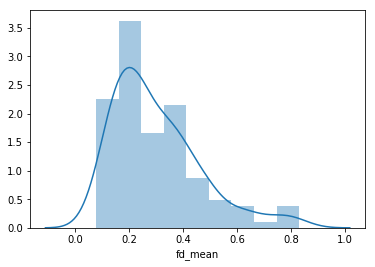

In [6]:
sns.distplot(bold_qa['fd_mean'])

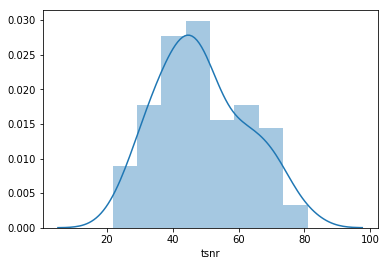

In [7]:
sns.distplot(bold_qa['tsnr'])

In [8]:
# eliminate people with fd_num >= 100 (threshold to keep number of regressors low)
bad_participants = bold_qa_select[bold_qa_select['fd_num'] >= 100]['participant_id'].unique()
bad_participants

array(['GE120003', 'GE120015', 'GE120020', 'GE120021', 'GE120024',
       'GE120026', 'GE120037', 'GE120038', 'GE120039', 'GE120043',
       'GE120045', 'GE120049', 'GE120052', 'GE120054', 'GE120055',
       'GE120059', 'GE120060', 'GE120065', 'GE120068', 'GE120069',
       'GE120075'], dtype=object)

In [9]:
# drop the num measurement
bold_qa_select.drop(columns='fd_num', inplace=True)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### load the participants tsv


In [10]:
participant_df = pd.read_csv(PARTICIPANT_DEMO, sep='\t')
participant_df_select = participant_df[["participant_id", "sex", "age", "education"]]
participant_df.head()

participant_id     sex  gender  age  education
0       GE120008  Female  Female   81         12
1       GE120007    Male    Male   83         14
2       GE120045    Male    Male   76         18
3       GE120046    Male    Male   74         21
4       GE120070    Male    Male   71         17

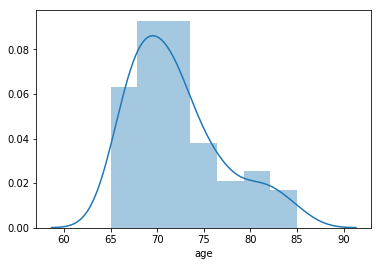

In [11]:
sns.distplot(participant_df['age'])

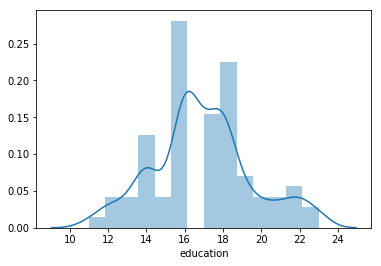

In [12]:
sns.distplot(participant_df['education'])

### Get the correlation files

In [13]:
lss_sch_layout = BIDSLayout(LSS_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lsa_sch_layout = BIDSLayout(LSA_SCH_PATH, validate=False, config=['bids', 'derivatives'])
lss_act_layout = BIDSLayout(LSS_ACT_PATH, validate=False, config=['bids', 'derivatives'])
lsa_act_layout = BIDSLayout(LSA_ACT_PATH, validate=False, config=['bids', 'derivatives'])

In [14]:
ent = lss_sch_layout.entities['subject']
good_participants = list(set(ent.unique()) - set(bad_participants))
len(good_participants)

40

In [15]:
# fb=fauxbold, ts=taskswitch
# act=activation, sch=schaefer
# lss=least squares separate, lsa=least squares all
fb_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

fb_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

ts_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

fb_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

fb_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold",
                                        subject=good_participants)

ts_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

ts_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch",
                                        subject=good_participants)

### Describe Demographics of the used participants

In [16]:
participant_df_select[participant_df_select['participant_id'].isin(ent)].describe(include='all')

participant_id     sex        age  education
count              61      61  61.000000  61.000000
unique             61       2        NaN        NaN
top          GE120032  Female        NaN        NaN
freq                1      31        NaN        NaN
mean              NaN     NaN  71.754098  17.065574
std               NaN     NaN   4.766745   2.657498
min               NaN     NaN  65.000000  12.000000
25%               NaN     NaN  69.000000  16.000000
50%               NaN     NaN  71.000000  17.000000
75%               NaN     NaN  73.000000  18.000000
max               NaN     NaN  85.000000  23.000000

In [17]:
participant_df_select = participant_df_select[participant_df_select['participant_id'].isin(good_participants)]

In [18]:
participant_df_select.describe(include='all')

participant_id     sex        age  education
count              40      40  40.000000  40.000000
unique             40       2        NaN        NaN
top          GE120023  Female        NaN        NaN
freq                1      21        NaN        NaN
mean              NaN     NaN  71.025000  16.950000
std               NaN     NaN   4.514861   2.745159
min               NaN     NaN  65.000000  12.000000
25%               NaN     NaN  68.000000  16.000000
50%               NaN     NaN  69.500000  17.000000
75%               NaN     NaN  72.250000  18.000000
max               NaN     NaN  83.000000  23.000000

## 1. Average within/between network correlations for task and null
I expect both the between and within network correlations to be higher during task, since there is a low likelihood of there being a BOLD response during the resting state data, and beta should not have a good fit for the rest data.
I'm only using the schaefer atlas for this hypothesis to measure the entire cortex.

In [19]:
# summarize the task data
with Pool(N_THREADS) as p:
    ts_dfs = p.starmap(nf.summarize_network_correlations,
                       [(f.path, f.entities['subject']) for f in ts_sch_lss_objs['switch']])
taskswitch_df = pd.concat(ts_dfs)
taskswitch_df.head()

network_connection source_network      mean participant_id
0            between          ContA  0.199278       GE120001
1            between          ContB  0.211870       GE120001
2            between          ContC  0.202784       GE120001
3            between       DefaultA  0.149841       GE120001
4            between       DefaultB  0.156266       GE120001

In [20]:
# summarize the rest data
with Pool(N_THREADS) as p:
    fb_dfs = p.starmap(nf.summarize_network_correlations,
                       [(f.path, f.entities['subject']) for f in fb_sch_lss_objs['switch']])
fauxbold_df = pd.concat(fb_dfs)
fauxbold_df.head()

network_connection source_network      mean participant_id
0            between          ContA  0.178436       GE120001
1            between          ContB  0.206108       GE120001
2            between          ContC  0.176003       GE120001
3            between       DefaultA  0.155126       GE120001
4            between       DefaultB  0.140301       GE120001

In [21]:
# combine taskswitch and fauxbold (task and rest)
taskswitch_df['data'] = ['taskswitch'] * taskswitch_df.shape[0]
fauxbold_df['data'] = ['fauxbold'] * fauxbold_df.shape[0]
data_df = pd.concat([taskswitch_df, fauxbold_df])

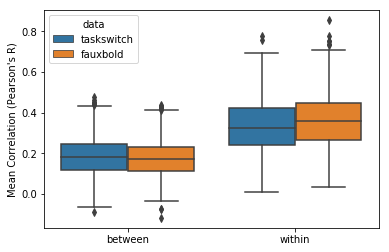

In [22]:
ax = sns.boxplot(x="network_connection", y="mean", hue='data', data=data_df)
ax.set_ylabel("Mean Correlation (Pearson's R)");
ax.set_xlabel("");


In [23]:
if not os.path.isfile("outputs/within_between.eps") or OVERWRITE_IMAGES:
    ax.figure.savefig("outputs/within_between.eps", dpi=1200)

### Overall within/between network correlations do not support hypothesis 1

The average within network correlations turn out to be a little **higher** in rest relative to task, contrary to my hypothesis.
In addition, the average between network correlation does not appear to differ betweentask and rest.

### Split average within/between correlation by network
This will identify whether there are some networks during rest that have higher within network correlations relative to task and some vice versa, or if the pattern is consistent throughout.

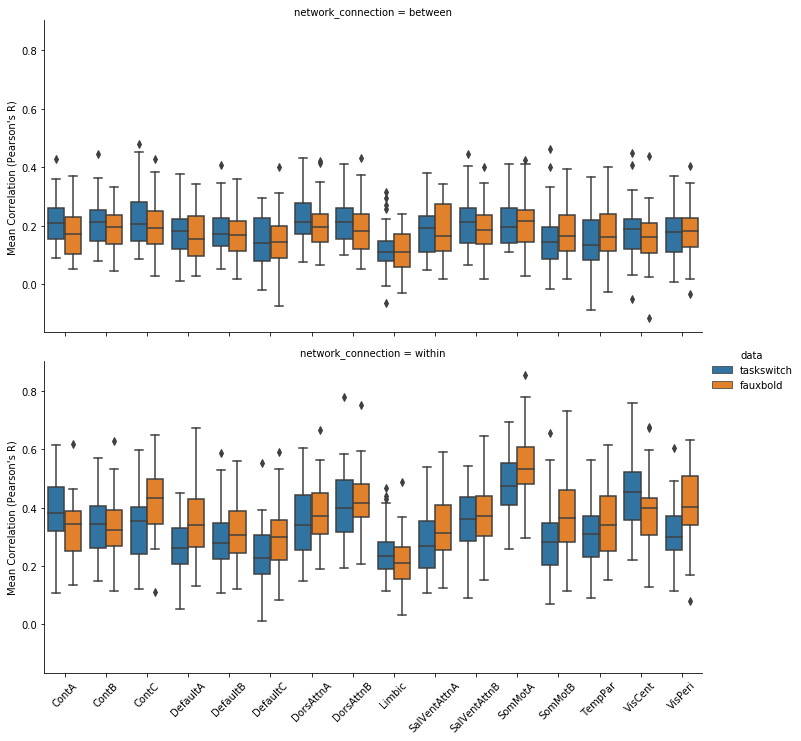

In [24]:
g = sns.catplot(kind='box', height=5, aspect=2,
            x='source_network', y='mean', row='network_connection',
            hue='data', data=data_df)

for ax in g.axes.flatten():
    ax.set_ylabel("Mean Correlation (Pearson's R)");

g.axes[1][0].set_xlabel("");
g.axes[1][0].set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45);


In [25]:
if not os.path.isfile("outputs/within_between_networks.eps") or OVERWRITE_IMAGES:
    g.savefig("outputs/within_between_networks.eps", bbox_inches="tight", dpi=1200)

### Average within/between network correlation do not differ across networks
The rest within network correlations appear **higher** than the task within network correlations across all networks.

## The condition contrast within the task will be greater than the condition contrast within rest
The task had multiple trial types (single, repeat, switch).
If beta series is able to pull out differences between trial types, the difference between switch and repeat during the task should be greater than the difference between "switch" and "repeat" during rest, since no actual events occurred during rest.

In [26]:
# task (switch - repeat)
with Pool(N_THREADS) as p:
    ts_diff_matrices = p.starmap(nf.calc_diff_matrices,
                                 [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(ts_sch_lss_objs['switch'], ts_sch_lss_objs['single'])])

taskswitch_diff = pd.concat(ts_diff_matrices)

In [27]:
# rest (switch - repeat)
with Pool(N_THREADS) as p:
    fb_diff_matrices = p.starmap(nf.calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(fb_sch_lss_objs['switch'], fb_sch_lss_objs['single'])])

fauxbold_diff = pd.concat(fb_diff_matrices)

In [28]:
taskswitch_diff['data'] = ['taskswitch'] * taskswitch_diff.shape[0]
fauxbold_diff['data'] = ['fauxbold'] * fauxbold_diff.shape[0]

In [29]:
diff_switch_repeat = pd.concat([taskswitch_diff, fauxbold_diff])
diff_switch_repeat.head()

index network_connection source_network      mean participant_id    mean_r  \
0      0            between          ContA -0.048799       GE120001 -0.048760   
1      1            between          ContB -0.015096       GE120001 -0.015095   
2      2            between          ContC -0.091551       GE120001 -0.091296   
3      3            between       DefaultA -0.077123       GE120001 -0.076970   
4      4            between       DefaultB -0.023852       GE120001 -0.023847   

         data  
0  taskswitch  
1  taskswitch  
2  taskswitch  
3  taskswitch  
4  taskswitch

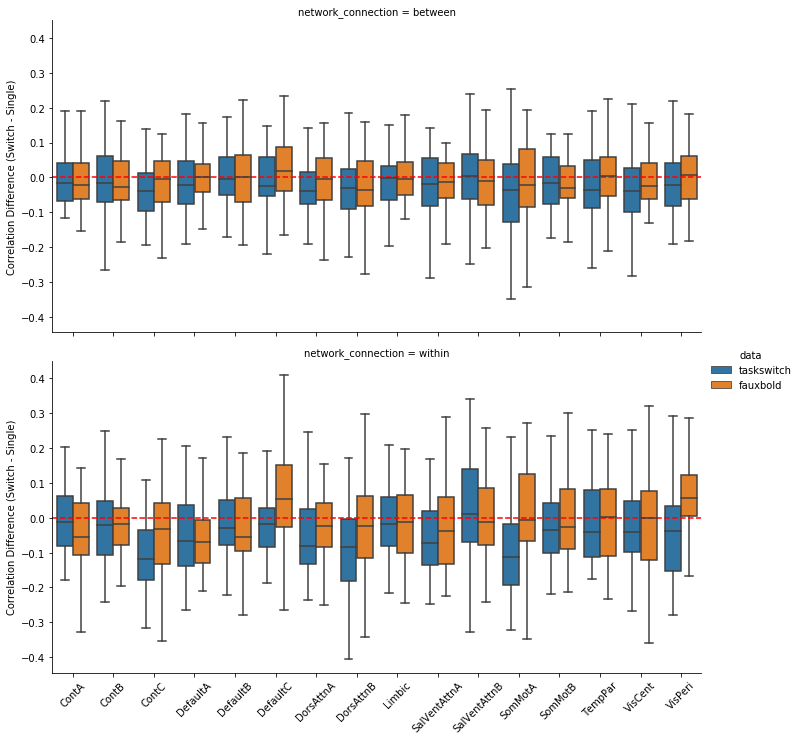

In [30]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean_r', row='network_connection', showfliers=False, hue='data', data=diff_switch_repeat)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--');
    ax.set_ylabel("Correlation Difference (Switch - Single)");

fg.axes[1][0].set_xlabel("");
fg.axes[1][0].set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45);

In [31]:
if not os.path.isfile("outputs/switch_repeat_difference.eps") or OVERWRITE_IMAGES:
    fg.savefig("outputs/switch_repeat_difference.eps", bbox_inches="tight", dpi=1200)

## 2. The correlation contrast between task and rest will be different from zero


In [32]:
with Pool(N_THREADS) as p:
    tsf_diff_matrices = p.starmap(nf.calc_diff_matrices, [(f1.path, f2.path, f1.entities['subject']) for f1, f2 in zip(ts_sch_lss_objs['switch'], fb_sch_lss_objs['switch'])])


task_faux_diff = pd.concat(tsf_diff_matrices)
task_faux_diff.head()

index network_connection source_network      mean participant_id    mean_r
0      0            between          ContA  0.028523       GE120001  0.028516
1      1            between          ContB  0.012500       GE120001  0.012500
2      2            between          ContC  0.030250       GE120001  0.030241
3      3            between       DefaultA -0.001634       GE120001 -0.001634
4      4            between       DefaultB  0.020914       GE120001  0.020910

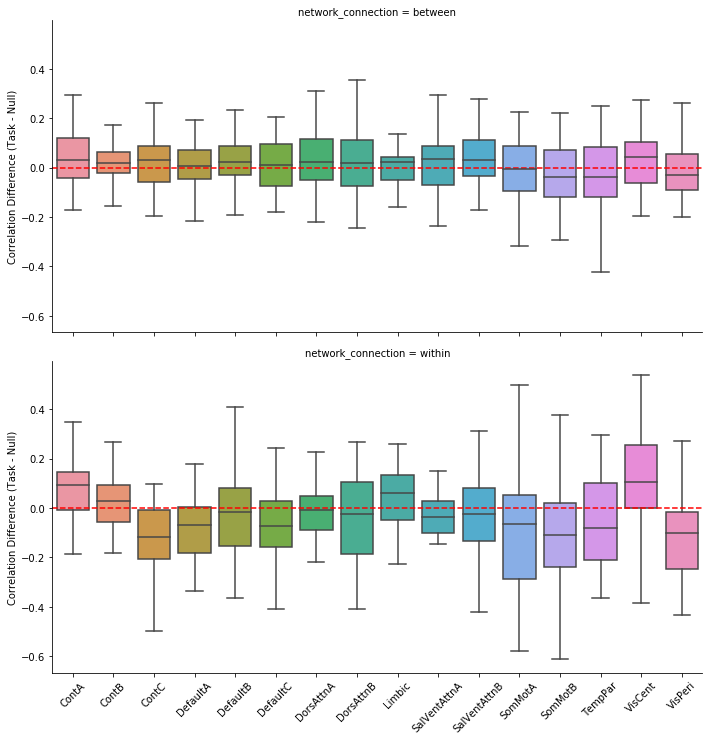

In [33]:
fg = sns.catplot(kind='box', height=5, aspect=2, x='source_network', y='mean_r', row='network_connection', showfliers=False, data=task_faux_diff)
for ax in fg.axes.flatten():
    ax.axhline(color='red', linestyle='--');
    ax.set_ylabel("Correlation Difference (Task - Null)");

fg.axes[1][0].set_xlabel("");
fg.axes[1][0].set_xticklabels(g.axes[1][0].get_xticklabels(), rotation=45);

In [34]:
if not os.path.isfile("outputs/task_rest_difference.eps") or OVERWRITE_IMAGES:
    fg.savefig("outputs/task_rest_difference.eps", bbox_inches="tight", dpi=600)

## model correlation differences between task and null

In [35]:
switch_wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['switch'], 'taskswitch'), nf.bind_matrices(fb_sch_lss_objs['switch'], 'fauxbold')])
switch_wide_df.head()

LH-VisCent-ExStr_1__LH-VisCent-ExStr_2  \
0                                0.173466   
1                                1.391233   
2                                0.251989   
3                                0.951592   
4                                1.249624   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_3  \
0                                1.635950   
1                                1.251663   
2                                0.956803   
3                                0.326724   
4                                1.037554   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_4  \
0                                1.201713   
1                                1.102269   
2                                1.193024   
3                                0.655183   
4                                1.043061   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_5  \
0                                0.956059   
1                                0.555580   
2                                0.675472   
3                                0.618965   
4                                0.972991   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_6  \
0                                1.152872   
1                                1.057460   
2                                0.464350   
3                                0.922814   
4                                1.024223   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_7  \
0                                0.972357   
1                                0.695299   
2                                0.758218   
3                                0.247573   
4                                0.645113   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_8  \
0                                0.374935   
1                                0.763697   
2                                0.216328   
3                                0.724745   
4                                1.091599   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_9  \
0                                0.652326   
1                                0.481084   
2                                0.053609   
3                                0.796385   
4                                0.984359   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_10  \
0                                -0.174632   
1                                 0.292104   
2                                 0.323872   
3                                 0.666413   
4                                 0.843333   

   LH-VisCent-ExStr_1__LH-VisCent-ExStr_11  ...  RH-TempPar-6__RH-TempPar-9  \
0                                 0.032021  ...                    0.370588   
1                                -0.497029  ...                    0.840588   
2                                -0.025488  ...                   -0.096037   
3                                 0.128919  ...                    0.155749   
4                                 0.329653  ...                    0.770283   

   RH-TempPar-6__RH-TempPar-10  RH-TempPar-7__RH-TempPar-8  \
0                     0.146798                    0.485977   
1                     0.442756                    1.600821   
2                     0.144772                    0.840178   
3                    -0.003123                    0.490772   
4                     0.151255                    1.302876   

   RH-TempPar-7__RH-TempPar-9  RH-TempPar-7__RH-TempPar-10  \
0                    0.342320                    -0.000323   
1                    0.987906                     0.668462   
2                   -0.072282                    -0.073852   
3                    0.471712                    -0.017250   
4                    0.901591                     0.561043   

   RH-TempPar-8__RH-TempPar-9  RH-TempPar-8__RH-TempPar-10  \
0                    0.494571                     0.190213   
1                    1.012779                     0.663280   
2                    0.079708                     0.136040   
3                    1.407445                     0.700278   
4                    0.6090

In [36]:
# bind qa measures
switch_wide_nr_df = pd.merge(switch_wide_df, bold_qa_select, how='left', on=['participant_id', 'task'])
switch_wide_nr_df = pd.merge(switch_wide_nr_df, participant_df_select, how='left', on=['participant_id'])

### Do not include nuisance regressors

In [37]:
model_df = nf.model_corr_diff_mt(switch_wide_df, N_THREADS)

In [38]:
p_value_df = nf.make_symmetric_df(model_df, "p_value")
estimate_df = nf.make_symmetric_df(model_df, "estimate")
display(p_value_df.head())
display(estimate_df.head())

ContA-LH_Cinga_1  ContA-LH_IPS_1  ContA-LH_IPS_2  \
ContA-LH_Cinga_1          0.000000        0.047670        0.664527   
ContA-LH_IPS_1            0.047670        0.000000        0.429472   
ContA-LH_IPS_2            0.664527        0.429472        0.000000   
ContA-LH_IPS_3            0.319773        0.002379        0.015485   
ContA-LH_IPS_4            0.204345        0.052022        0.036288   

                  ContA-LH_IPS_3  ContA-LH_IPS_4  ContA-LH_IPS_5  \
ContA-LH_Cinga_1        0.319773        0.204345        0.980440   
ContA-LH_IPS_1          0.002379        0.052022        0.004840   
ContA-LH_IPS_2          0.015485        0.036288        0.187292   
ContA-LH_IPS_3          0.000000        0.000692        0.002260   
ContA-LH_IPS_4          0.000692        0.000000        0.621523   

                  ContA-LH_PFCd_1  ContA-LH_PFCl_1  ContA-LH_PFCl_2  \
ContA-LH_Cinga_1         0.157540         0.116361         0.081265   
ContA-LH_IPS_1           0.332847         0.100389         0.020555   
ContA-LH_IPS_2           0.627198         0.703525         0.343823   
ContA-LH_IPS_3           0.353552         0.010853         0.004908   
ContA-LH_IPS_4           0.732584         0.004142         0.000098   

                  ContA-LH_PFCl_3  ...  VisPeri-RH_ExStrSup_10  \
ContA-LH_Cinga_1         0.704935  ...                0.587907   
ContA-LH_IPS_1           0.049377  ...                0.736943   
ContA-LH_IPS_2           0.029736  ...                0.697255   
ContA-LH_IPS_3           0.409139  ...                0.291752   
ContA-LH_IPS_4           0.086379  ...                0.255032   

                  VisPeri-RH_ExStrSup_11  VisPeri-RH_ExStrSup_2  \
ContA-LH_Cinga_1                0.050960               0.506635   
ContA-LH_IPS_1                  0.158087               0.767106   
ContA-LH_IPS_2                  0.339283               0.956970   
ContA-LH_IPS_3                  0.165137               0.503688   
ContA-LH_IPS_4                  0.652502               0.042930   

                  VisPeri-RH_ExStrSup_3  VisPeri-RH_ExStrSup_4  \
ContA-LH_Cinga_1               0.786160               0.872382   
ContA-LH_IPS_1                 0.524573               0.759469   
ContA-LH_IPS_2                 0.286751               0.667061   
ContA-LH_IPS_3                 0.260050               0.536726   
ContA-LH_IPS_4                 0.055912               0.768115   

                  VisPeri-RH_ExStrSup_5  VisPeri-RH_ExStrSup_6  \
ContA-LH_Cinga_1               0.628716               0.915999   
ContA-LH_IPS_1                 0.851246               0.128547   
ContA-LH_IPS_2                 0.701278               0.736766   
ContA-LH_IPS_3                 0.768602               0.073777   
ContA-LH_IPS_4                 0.655716               0.005153   

                  VisPeri-RH_ExStrSup_7  VisPeri-RH_ExStrSup_8  \
ContA-LH_Cinga_1               0.777518               0.442195   
ContA-LH_IPS_1                 0.806467               0.471641   
ContA-LH_IPS_2                 0.249331               0.361893   
ContA-LH_IPS_3                 0.936319               0.764728   
ContA-LH_IPS_4                 0.846990               0.967251   

                  VisPeri-RH_ExStrSup_9  
ContA-LH_Cinga_1               0.248137  
ContA-LH_IPS_1                 0.620540  
ContA-LH_IPS_2                 0.341976  
ContA-LH_IPS_3                 0.043247  
ContA-LH_IPS_4                 0.377785  

[5 rows x 400 columns]

ContA-LH_Cinga_1  ContA-LH_IPS_1  ContA-LH_IPS_2  \
ContA-LH_Cinga_1          0.000000       -0.130480       -0.033745   
ContA-LH_IPS_1           -0.130480        0.000000        0.053372   
ContA-LH_IPS_2           -0.033745        0.053372        0.000000   
ContA-LH_IPS_3           -0.075108        0.245912        0.199047   
ContA-LH_IPS_4            0.095314        0.137932        0.173320   

                  ContA-LH_IPS_3  ContA-LH_IPS_4  ContA-LH_IPS_5  \
ContA-LH_Cinga_1       -0.075108        0.095314        0.001578   
ContA-LH_IPS_1          0.245912        0.137932        0.213044   
ContA-LH_IPS_2          0.199047        0.173320        0.093128   
ContA-LH_IPS_3          0.000000        0.272285        0.250787   
ContA-LH_IPS_4          0.272285        0.000000        0.038085   

                  ContA-LH_PFCd_1  ContA-LH_PFCl_1  ContA-LH_PFCl_2  \
ContA-LH_Cinga_1        -0.103136        -0.116380        -0.141440   
ContA-LH_IPS_1          -0.068657         0.132496         0.162880   
ContA-LH_IPS_2          -0.036751         0.030776         0.078465   
ContA-LH_IPS_3          -0.064262         0.243171         0.251229   
ContA-LH_IPS_4          -0.024107         0.251026         0.350039   

                  ContA-LH_PFCl_3  ...  VisPeri-RH_ExStrSup_10  \
ContA-LH_Cinga_1        -0.031552  ...               -0.039582   
ContA-LH_IPS_1           0.169776  ...                0.024639   
ContA-LH_IPS_2           0.200557  ...               -0.028185   
ContA-LH_IPS_3           0.075333  ...               -0.079152   
ContA-LH_IPS_4           0.142891  ...               -0.075239   

                  VisPeri-RH_ExStrSup_11  VisPeri-RH_ExStrSup_2  \
ContA-LH_Cinga_1               -0.160098              -0.052080   
ContA-LH_IPS_1                  0.117873              -0.019993   
ContA-LH_IPS_2                  0.074008               0.004668   
ContA-LH_IPS_3                  0.111289               0.055776   
ContA-LH_IPS_4                  0.035312               0.146470   

                  VisPeri-RH_ExStrSup_3  VisPeri-RH_ExStrSup_4  \
ContA-LH_Cinga_1               0.022139               0.014222   
ContA-LH_IPS_1                 0.042796              -0.019541   
ContA-LH_IPS_2                 0.078192               0.029519   
ContA-LH_IPS_3                 0.088570               0.046430   
ContA-LH_IPS_4                 0.115029               0.019969   

                  VisPeri-RH_ExStrSup_5  VisPeri-RH_ExStrSup_6  \
ContA-LH_Cinga_1              -0.041975              -0.007186   
ContA-LH_IPS_1                -0.013759               0.088385   
ContA-LH_IPS_2                -0.029027              -0.022477   
ContA-LH_IPS_3                 0.026173               0.123432   
ContA-LH_IPS_4                 0.032778               0.156488   

                  VisPeri-RH_ExStrSup_7  VisPeri-RH_ExStrSup_8  \
ContA-LH_Cinga_1              -0.021215              -0.052460   
ContA-LH_IPS_1                 0.017290              -0.047898   
ContA-LH_IPS_2                -0.081065              -0.055217   
ContA-LH_IPS_3                 0.005544               0.019810   
ContA-LH_IPS_4                -0.013216               0.002480   

                  VisPeri-RH_ExStrSup_9  
ContA-LH_Cinga_1              -0.075207  
ContA-LH_IPS_1                 0.034127  
ContA-LH_IPS_2                 0.065212  
ContA-LH_IPS_3                 0.136432  
ContA-LH_IPS_4                 0.056447  

[5 rows x 400 columns]

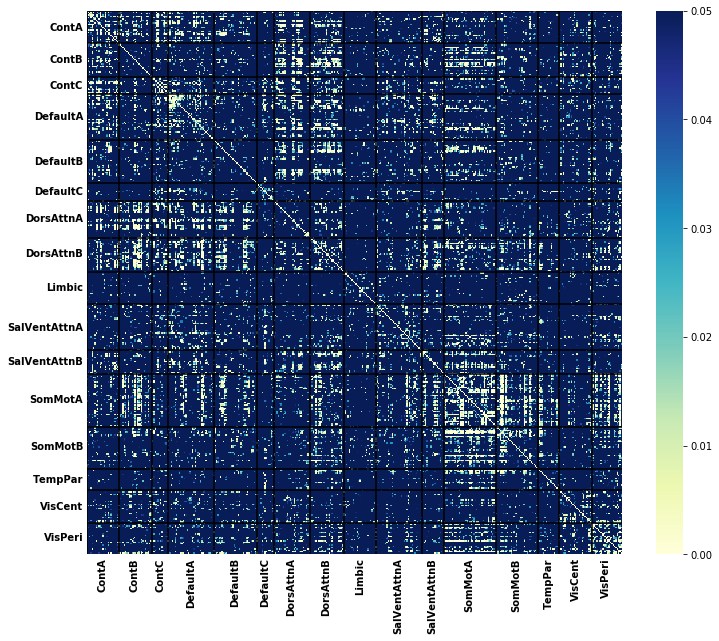

In [39]:
f = nf._make_pretty_schaefer_heatmap(p_value_df, vmin=0.0, vmax=0.05, cmap="YlGnBu")

In [40]:
if not os.path.isfile("outputs/task_null_difference_heatmap_pval.eps") or OVERWRITE_IMAGES:
    f.savefig("outputs/task_null_difference_heatmap_pval.eps", bbox_inches="tight", dpi=600)

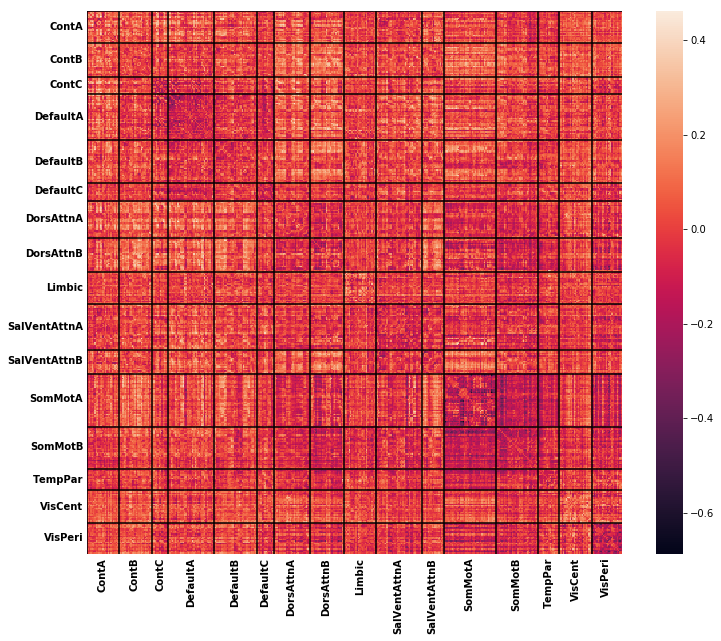

In [41]:
f = nf._make_pretty_schaefer_heatmap(estimate_df)

In [42]:
if not os.path.isfile("outputs/task_rest_difference_heatmap_estimates.eps") or OVERWRITE_IMAGES:
    f.savefig("outputs/task_rest_difference_heatmap_estimates.eps", bbox_inches="tight", dpi=600)

In [43]:
idxs = np.triu_indices(p_value_df.shape[0], k=1)
# false discovery rate (Benjamini/Hochberg)
p_values_sig, p_value_fdr, _, _ = multipletests(p_value_df.values[idxs], alpha=0.05, method='fdr_bh')
# show the fdr corrected values
p_value_fdr[p_values_sig]

array([0.00428199, 0.04371776, 0.03246989, ..., 0.02155162, 0.01290095,
       0.02368585])

In [44]:
p_value_fdr[p_values_sig].shape

(1333,)

### Include framewise displacement, tsnr, age, sex, and education

In [45]:
model_nr_df = nf.model_corr_diff_mt(switch_wide_nr_df, N_THREADS, ['fd_mean', 'tsnr', 'age', 'sex', 'education'])

In [46]:
p_value_nr_df = nf.make_symmetric_df(model_nr_df, "p_value")
estimate_nr_df = nf.make_symmetric_df(model_nr_df, "estimate")
display(p_value_nr_df.head())
display(estimate_nr_df.head())

ContA-LH_Cinga_1  ContA-LH_IPS_1  ContA-LH_IPS_2  \
ContA-LH_Cinga_1          0.000000        0.059043        0.807690   
ContA-LH_IPS_1            0.059043        0.000000        0.471041   
ContA-LH_IPS_2            0.807690        0.471041        0.000000   
ContA-LH_IPS_3            0.726693        0.003389        0.015625   
ContA-LH_IPS_4            0.033459        0.127283        0.045933   

                  ContA-LH_IPS_3  ContA-LH_IPS_4  ContA-LH_IPS_5  \
ContA-LH_Cinga_1        0.726693        0.033459        0.694309   
ContA-LH_IPS_1          0.003389        0.127283        0.011331   
ContA-LH_IPS_2          0.015625        0.045933        0.068911   
ContA-LH_IPS_3          0.000000        0.001120        0.003525   
ContA-LH_IPS_4          0.001120        0.000000        0.743171   

                  ContA-LH_PFCd_1  ContA-LH_PFCl_1  ContA-LH_PFCl_2  \
ContA-LH_Cinga_1         0.309663         0.097483         0.031486   
ContA-LH_IPS_1           0.398774         0.224466         0.047667   
ContA-LH_IPS_2           0.753616         0.866006         0.923447   
ContA-LH_IPS_3           0.306628         0.019262         0.016228   
ContA-LH_IPS_4           0.881687         0.003700         0.000345   

                  ContA-LH_PFCl_3  ...  VisPeri-RH_ExStrSup_10  \
ContA-LH_Cinga_1         0.682352  ...                0.976107   
ContA-LH_IPS_1           0.071013  ...                0.604755   
ContA-LH_IPS_2           0.111002  ...                0.923026   
ContA-LH_IPS_3           0.816552  ...                0.498710   
ContA-LH_IPS_4           0.184518  ...                0.338465   

                  VisPeri-RH_ExStrSup_11  VisPeri-RH_ExStrSup_2  \
ContA-LH_Cinga_1                0.193248               0.220506   
ContA-LH_IPS_1                  0.076642               0.880021   
ContA-LH_IPS_2                  0.277105               0.741183   
ContA-LH_IPS_3                  0.136554               0.317444   
ContA-LH_IPS_4                  0.868463               0.023002   

                  VisPeri-RH_ExStrSup_3  VisPeri-RH_ExStrSup_4  \
ContA-LH_Cinga_1               0.501275               0.761950   
ContA-LH_IPS_1                 0.568430               0.697958   
ContA-LH_IPS_2                 0.112059               0.441933   
ContA-LH_IPS_3                 0.196499               0.553562   
ContA-LH_IPS_4                 0.023050               0.722924   

                  VisPeri-RH_ExStrSup_5  VisPeri-RH_ExStrSup_6  \
ContA-LH_Cinga_1               0.947145               0.781948   
ContA-LH_IPS_1                 0.600552               0.276152   
ContA-LH_IPS_2                 0.308206               0.949191   
ContA-LH_IPS_3                 0.825226               0.075920   
ContA-LH_IPS_4                 0.839747               0.002265   

                  VisPeri-RH_ExStrSup_7  VisPeri-RH_ExStrSup_8  \
ContA-LH_Cinga_1               0.988992               0.599617   
ContA-LH_IPS_1                 0.866716               0.491147   
ContA-LH_IPS_2                 0.153429               0.672853   
ContA-LH_IPS_3                 0.473864               0.616036   
ContA-LH_IPS_4                 0.430272               0.837248   

                  VisPeri-RH_ExStrSup_9  
ContA-LH_Cinga_1               0.407890  
ContA-LH_IPS_1                 0.979366  
ContA-LH_IPS_2                 0.605177  
ContA-LH_IPS_3                 0.145729  
ContA-LH_IPS_4                 0.872732  

[5 rows x 400 columns]

ContA-LH_Cinga_1  ContA-LH_IPS_1  ContA-LH_IPS_2  \
ContA-LH_Cinga_1          0.000000       -0.134644        0.020472   
ContA-LH_IPS_1           -0.134644        0.000000        0.052917   
ContA-LH_IPS_2            0.020472        0.052917        0.000000   
ContA-LH_IPS_3           -0.028203        0.249520        0.213431   
ContA-LH_IPS_4            0.164440        0.113354        0.180266   

                  ContA-LH_IPS_3  ContA-LH_IPS_4  ContA-LH_IPS_5  \
ContA-LH_Cinga_1       -0.028203        0.164440        0.026392   
ContA-LH_IPS_1          0.249520        0.113354        0.204089   
ContA-LH_IPS_2          0.213431        0.180266        0.138551   
ContA-LH_IPS_3          0.000000        0.269020        0.256062   
ContA-LH_IPS_4          0.269020        0.000000        0.025027   

                  ContA-LH_PFCd_1  ContA-LH_PFCl_1  ContA-LH_PFCl_2  \
ContA-LH_Cinga_1        -0.080826        -0.129289        -0.188185   
ContA-LH_IPS_1          -0.059629         0.104442         0.148128   
ContA-LH_IPS_2          -0.025769        -0.014292         0.008229   
ContA-LH_IPS_3          -0.068351         0.238036         0.219570   
ContA-LH_IPS_4          -0.010811         0.259498         0.328023   

                  ContA-LH_PFCl_3  ...  VisPeri-RH_ExStrSup_10  \
ContA-LH_Cinga_1        -0.037251  ...               -0.002359   
ContA-LH_IPS_1           0.167270  ...                0.040240   
ContA-LH_IPS_2           0.153822  ...                0.007610   
ContA-LH_IPS_3           0.021057  ...               -0.051181   
ContA-LH_IPS_4           0.113402  ...               -0.064554   

                  VisPeri-RH_ExStrSup_11  VisPeri-RH_ExStrSup_2  \
ContA-LH_Cinga_1               -0.112095              -0.098551   
ContA-LH_IPS_1                  0.160193              -0.011194   
ContA-LH_IPS_2                  0.091548               0.030576   
ContA-LH_IPS_3                  0.127962               0.091004   
ContA-LH_IPS_4                  0.014079               0.177078   

                  VisPeri-RH_ExStrSup_3  VisPeri-RH_ExStrSup_4  \
ContA-LH_Cinga_1               0.058999               0.027547   
ContA-LH_IPS_1                 0.040453              -0.026626   
ContA-LH_IPS_2                 0.121184               0.056803   
ContA-LH_IPS_3                 0.106142               0.047215   
ContA-LH_IPS_4                 0.143061               0.025024   

                  VisPeri-RH_ExStrSup_5  VisPeri-RH_ExStrSup_6  \
ContA-LH_Cinga_1               0.005833               0.019484   
ContA-LH_IPS_1                -0.041083               0.067433   
ContA-LH_IPS_2                -0.080637               0.004428   
ContA-LH_IPS_3                -0.020294               0.132604   
ContA-LH_IPS_4                -0.014641               0.175585   

                  VisPeri-RH_ExStrSup_7  VisPeri-RH_ExStrSup_8  \
ContA-LH_Cinga_1              -0.001136              -0.038726   
ContA-LH_IPS_1                -0.012528              -0.049904   
ContA-LH_IPS_2                -0.106050              -0.025702   
ContA-LH_IPS_3                -0.051354               0.035464   
ContA-LH_IPS_4                -0.054505               0.013031   

                  VisPeri-RH_ExStrSup_9  
ContA-LH_Cinga_1              -0.057430  
ContA-LH_IPS_1                 0.001901  
ContA-LH_IPS_2                 0.037685  
ContA-LH_IPS_3                 0.105129  
ContA-LH_IPS_4                 0.010454  

[5 rows x 400 columns]

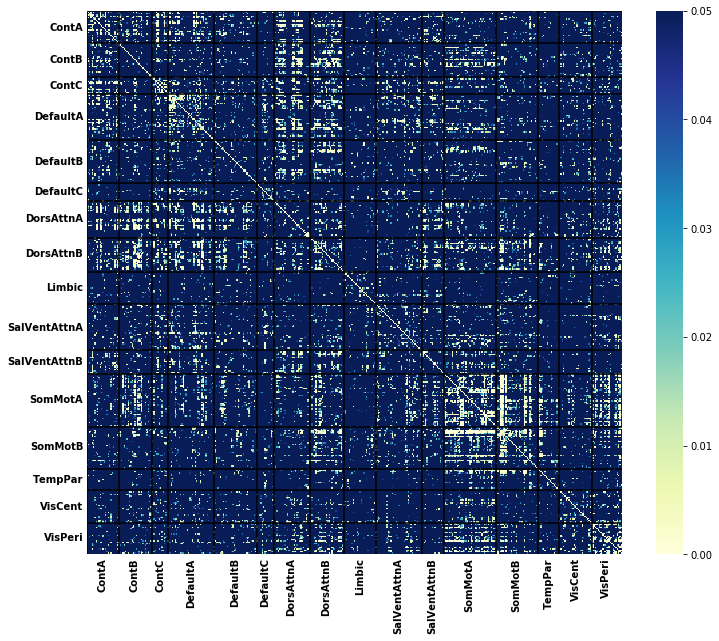

In [47]:
f = nf._make_pretty_schaefer_heatmap(p_value_nr_df, vmin=0.0, vmax=0.05, cmap="YlGnBu")

In [48]:
# false discovery rate (Benjamini/Hochberg)
p_values_sig, p_value_fdr, _, _ = multipletests(p_value_nr_df.values[idxs], alpha=0.05, method='fdr_bh')
# still significant differences...
display(p_value_fdr[p_values_sig].shape)


(849,)

## 3. The correlation contrasts between task/null, switch/single, repeat/single, and switch/repeat will have more positives using LSS relative to LSA.

In [49]:
# collect permutations and number of significant values found for each condition
permutation_collector = {
    'atlas': [],
    'data': [],
    'contrast': [],
    'estimator': [],
    'participants': [],
    'permutations': [],
    'observed_value': [],
    'p_value': [],
}

In [50]:
# regions with the best CNR
import pickle
with open('outputs/schaefer_best_cnr.pkl', "rb") as fp:
    best_regions_orig = pickle.load(fp)
best_regions = [nf._flip_hemisphere_network(w) for w in best_regions_orig]
best_regions

['Limbic-RH_OFC_5',
 'DefaultC-LH_PHC_1',
 'VisCent-RH_ExStr_9',
 'VisCent-RH_ExStr_5',
 'VisCent-LH_ExStr_3',
 'DefaultA-LH_PCC_6',
 'VisCent-RH_ExStr_4',
 'VisPeri-LH_ExStrSup_6',
 'Limbic-LH_OFC_3',
 'VisCent-LH_ExStr_4',
 'Limbic-RH_OFC_3',
 'Limbic-LH_TempPole_2',
 'Limbic-RH_TempPole_5',
 'Limbic-LH_TempPole_7',
 'ContA-LH_IPS_1',
 'VisCent-LH_ExStr_7',
 'VisCent-LH_ExStr_5',
 'VisCent-RH_ExStr_6',
 'VisCent-RH_ExStr_2',
 'VisCent-RH_ExStr_7']

In [51]:
# for making activation atlas glass brain images
coords_df = pd.read_csv('../firstLevelAnalysis/outputs/cluster_table.tsv', sep='\t')

###  Schaefer Atlas: task - null

Number of Positives lsa: 11486 / 79800
Number of Positives lss: 13736 / 79800
Number of overlapping positives: 5554 / 79800


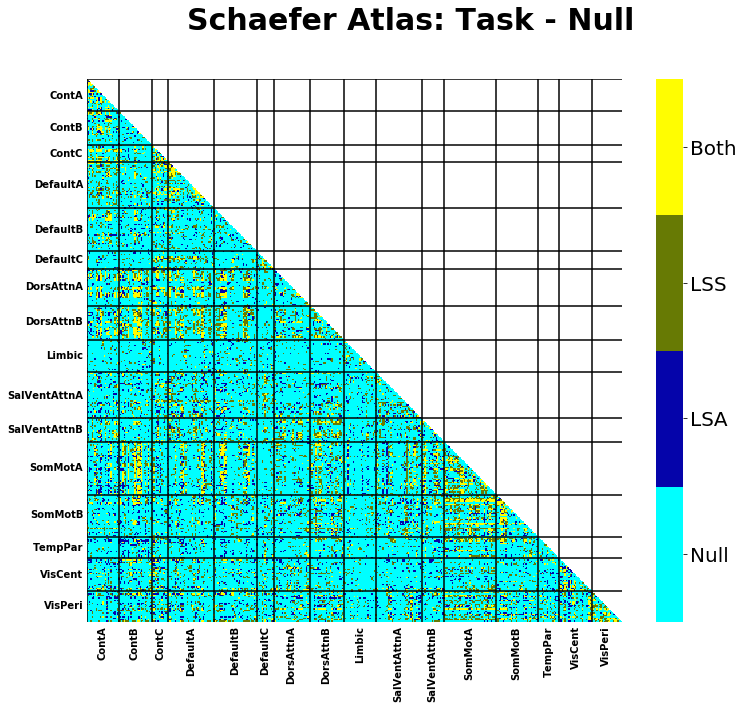

In [52]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       fb_sch_lss_objs['switch'],
                       ts_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['switch'],
                       'task', 'null',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-schaefer_contrast-taskXnull.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

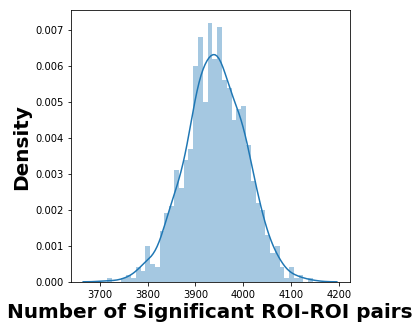

In [53]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-taskxnull_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_sch_lss_objs['switch'], fb_sch_lss_objs['switch'],
        'task', 'null', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)) // 10, ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [54]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

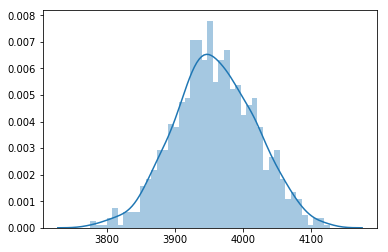

In [55]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-taskxnull_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_sch_lsa_objs['switch'], fb_sch_lsa_objs['switch'],
        'task', 'null', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)) // 10)
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [56]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [57]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

32

In [58]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

28

In [59]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

26

0.0

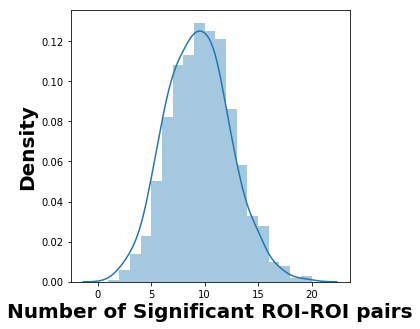

In [64]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-taskxnull_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['switch'], 'task', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lss_objs['switch'], 'null', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [65]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

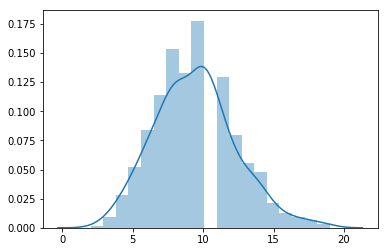

In [66]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-taskxnull_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lsa_objs['switch'], 'task', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lsa_objs['switch'], 'null', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [67]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [68]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(2263,)

In [69]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(1132,)

###  Activation Atlas: task - null

Number of Positives lsa: 22 / 210
Number of Positives lss: 27 / 210
Number of overlapping positives: 9 / 210


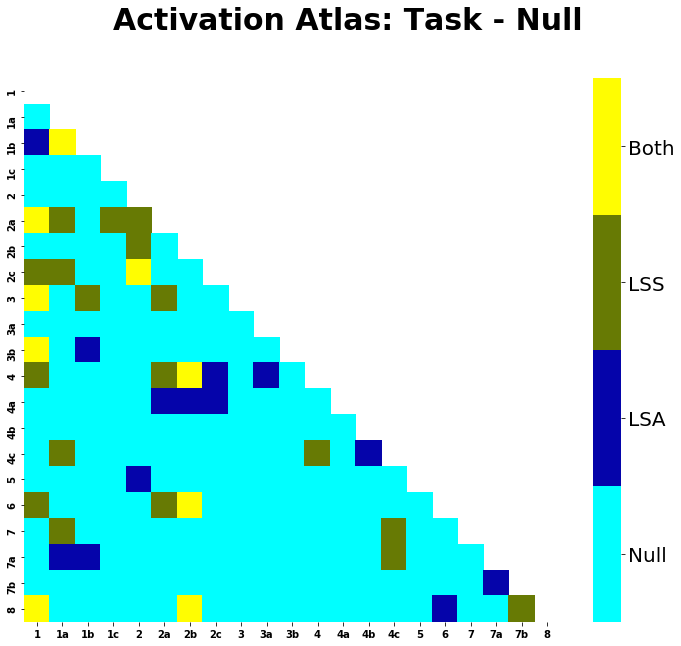

In [70]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       fb_act_lss_objs['switch'],
                       ts_act_lsa_objs['switch'],
                       fb_act_lsa_objs['switch'],
                       'task', 'null',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-activation_contrast-taskXnull'
save_eps(fig, outfile)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(axes, collections.Sequence):


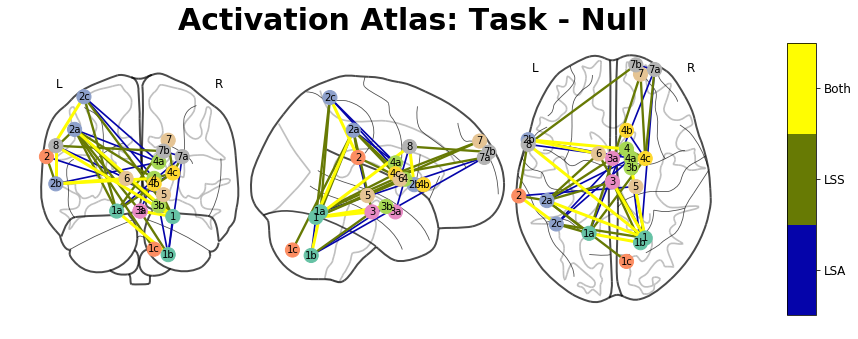

In [71]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_type-brain_atlas-activation_contrast-taskXnull'
save_eps(fig, outfile)

In [72]:
fig.suptitle("")
save_eps(fig, outfile + '_separate')

0.0

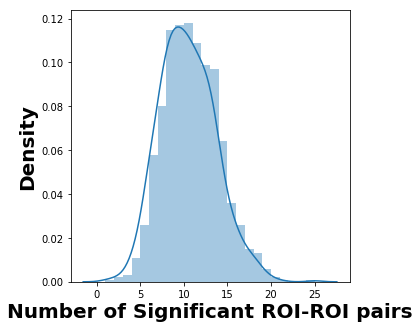

In [73]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-taskxnull_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['switch'], fb_act_lss_objs['switch'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [74]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.001

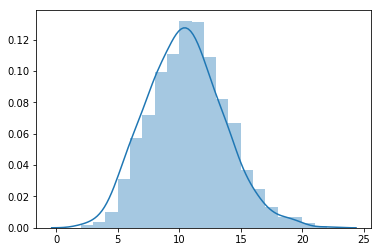

In [75]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-taskxnull_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['switch'], fb_act_lsa_objs['switch'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [76]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [77]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_model_df[lss_sig_array])
display(lss_fdr_pvalues[lss_sig_array].shape)

Empty DataFrame
Columns: [source_target, estimate, p_value, source, target]
Index: []

(0,)

In [78]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_model_df[lsa_sig_array])
display(lsa_fdr_pvalues[lsa_sig_array].shape)

Empty DataFrame
Columns: [source_target, estimate, p_value, source, target]
Index: []

(0,)

LSS has one result that survives FDR correction whereas LSA has no results that survive 

### Schaefer Atlas: switch - single (task)

Number of Positives lsa: 6363 / 79800
Number of Positives lss: 6625 / 79800
Number of overlapping positives: 1049 / 79800


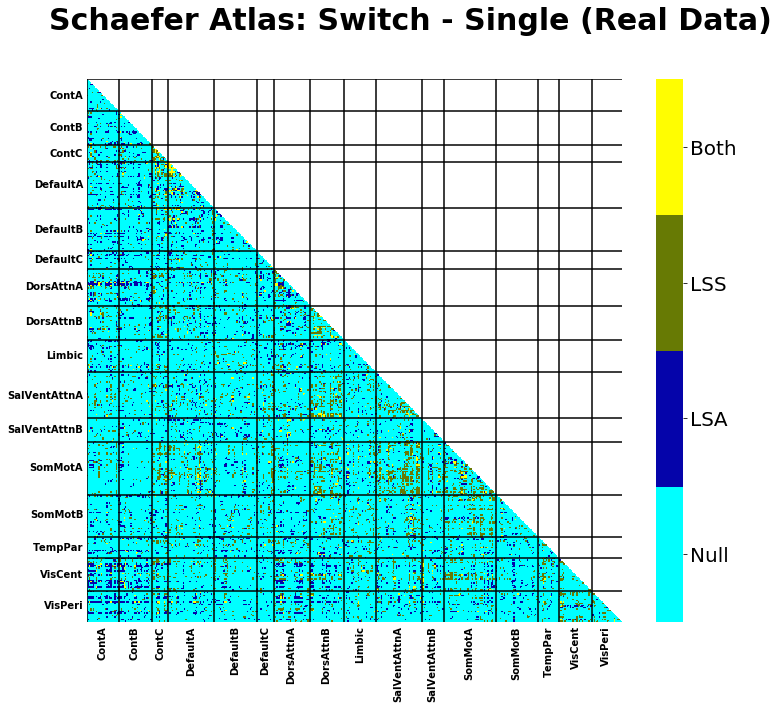

In [79]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['switch'],
                       ts_sch_lsa_objs['single'],
                       'switch', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

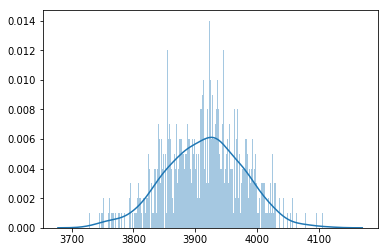

In [80]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_sch_lss_objs['switch'], ts_sch_lss_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [81]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

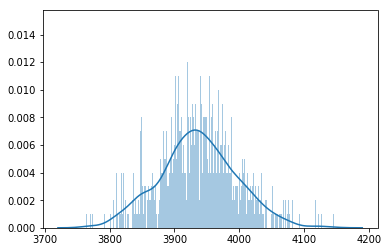

In [82]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_sch_lsa_objs['switch'], ts_sch_lsa_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [83]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [84]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

32

In [85]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

14

In [86]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

4

0.577

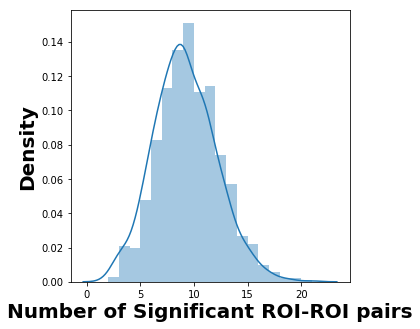

In [87]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['switch'], 'switch', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lss_objs['single'], 'single', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [88]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.01

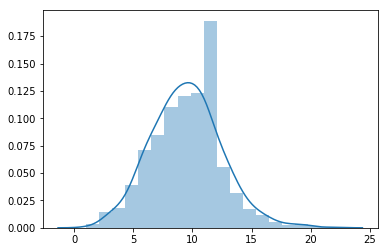

In [89]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lsa_objs['switch'], 'switch', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lsa_objs['single'], 'single', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [90]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [91]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [92]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(15,)

### Schaefer Atlas: switch - single (null)

Number of Positives lsa: 4610 / 79800
Number of Positives lss: 5101 / 79800
Number of overlapping positives: 764 / 79800


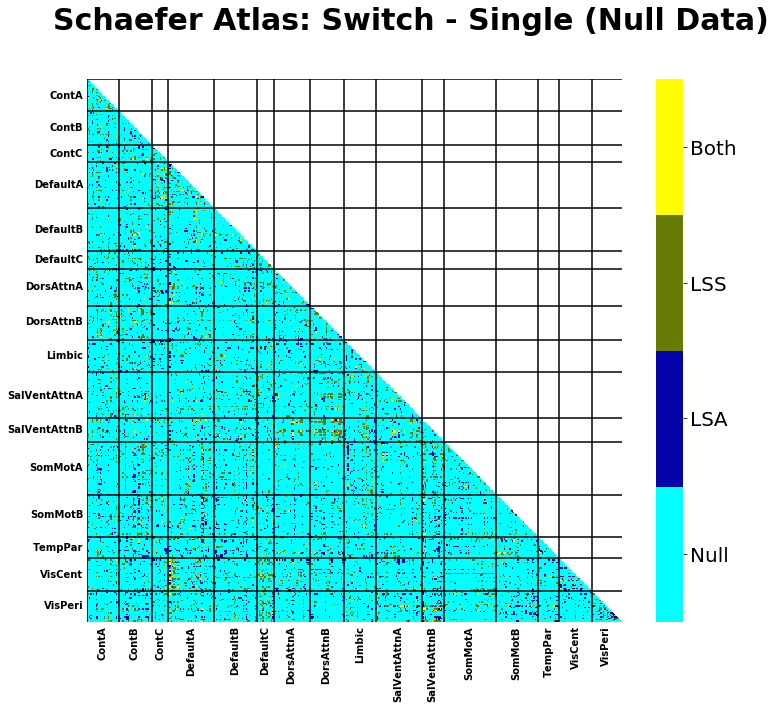

In [93]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['switch'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['single'],
                       'switch', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-switchXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

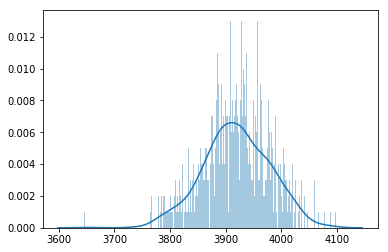

In [94]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_sch_lss_objs['switch'], fb_sch_lss_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [95]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

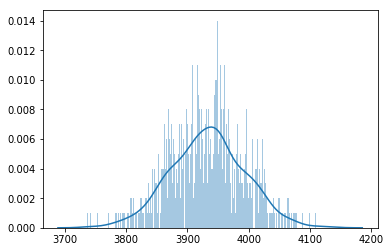

In [96]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_sch_lsa_objs['switch'], fb_sch_lsa_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [97]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [98]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

20

In [99]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

10

In [100]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

6

0.708

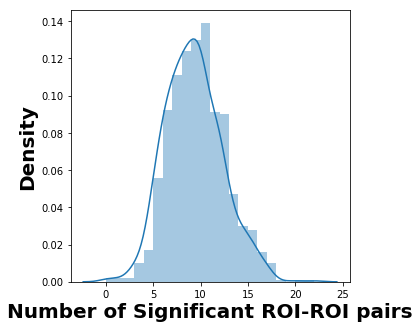

In [101]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-taskxnull_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lss_objs['switch'], 'switch', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lss_objs['single'], 'single', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [102]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.144

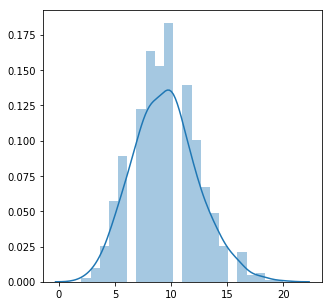

In [103]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lsa_objs['switch'], 'switch', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lsa_objs['single'], 'single', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [104]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [105]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [106]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: switch - single (task)

Number of Positives lsa: 11 / 210
Number of Positives lss: 10 / 210
Number of overlapping positives: 1 / 210


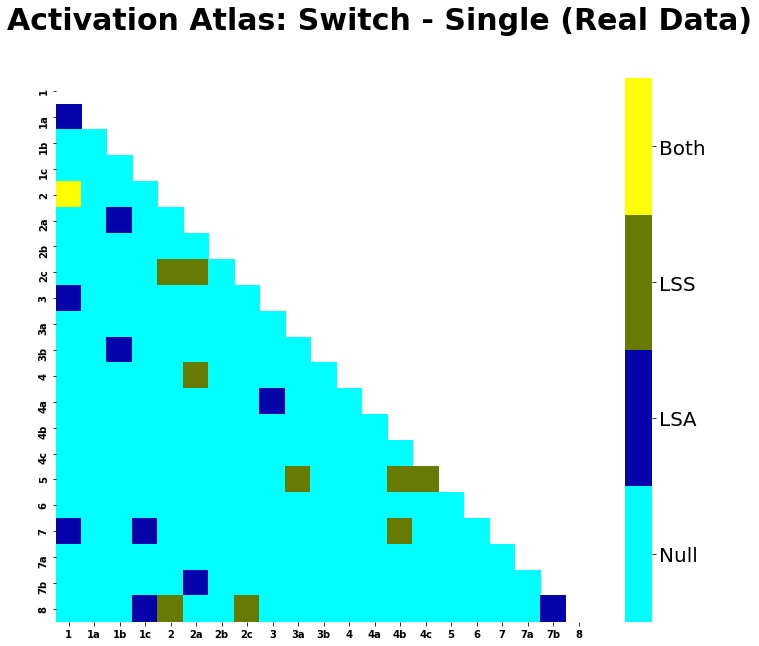

In [107]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['switch'],
                       ts_act_lsa_objs['single'],
                       'switch', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-switchXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

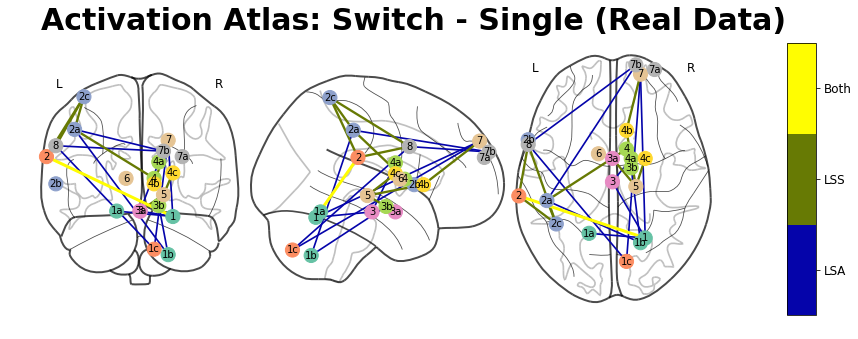

In [108]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-switchXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

#### Permutation test to see if number of significant results is expected

0.581

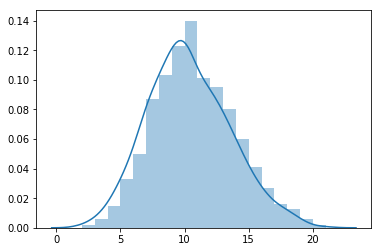

In [109]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['switch'], ts_act_lss_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [110]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.477

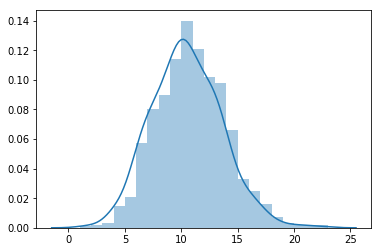

In [111]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['switch'], ts_act_lsa_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [112]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [113]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [114]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: switch - single (null)

Number of Positives lsa: 12 / 210
Number of Positives lss: 13 / 210
Number of overlapping positives: 2 / 210


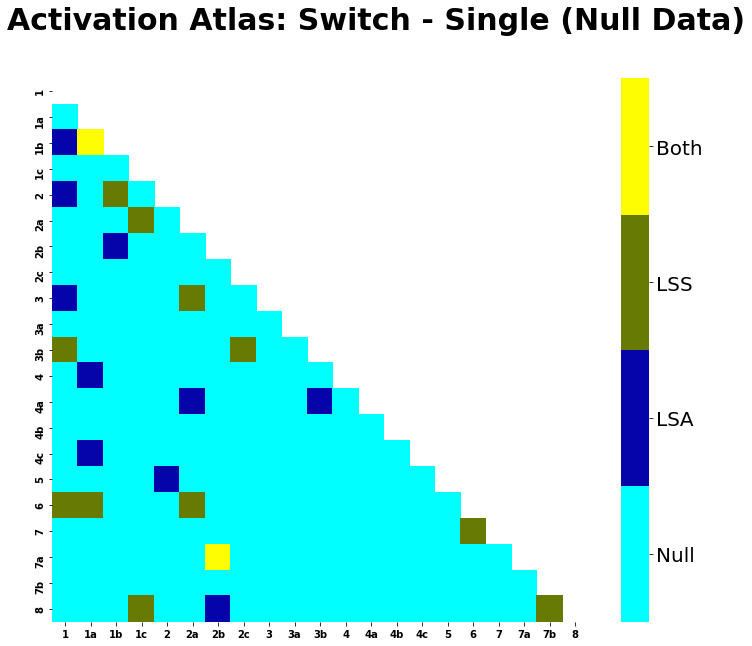

In [115]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['switch'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['switch'],
                       fb_act_lsa_objs['single'],
                       'switch', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-switchXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

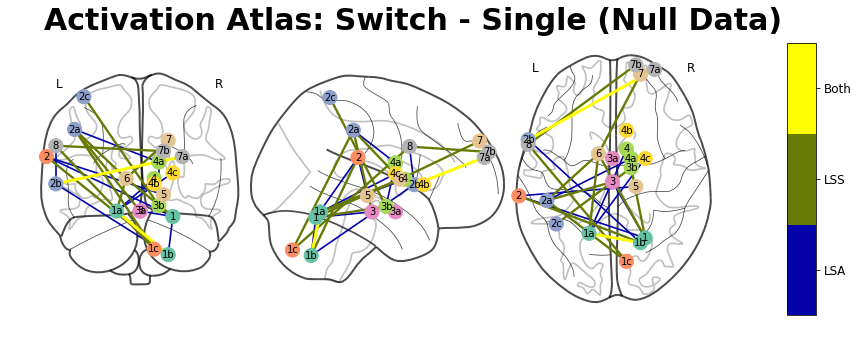

In [116]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-switchXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.223

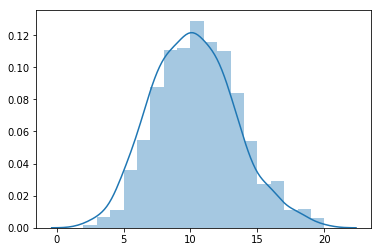

In [117]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['switch'], fb_act_lss_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [118]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.359

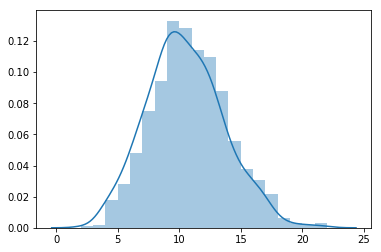

In [119]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['switch'], fb_act_lsa_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [120]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [121]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [122]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: repeat - single (task)

Number of Positives lsa: 5504 / 79800
Number of Positives lss: 5256 / 79800
Number of overlapping positives: 801 / 79800


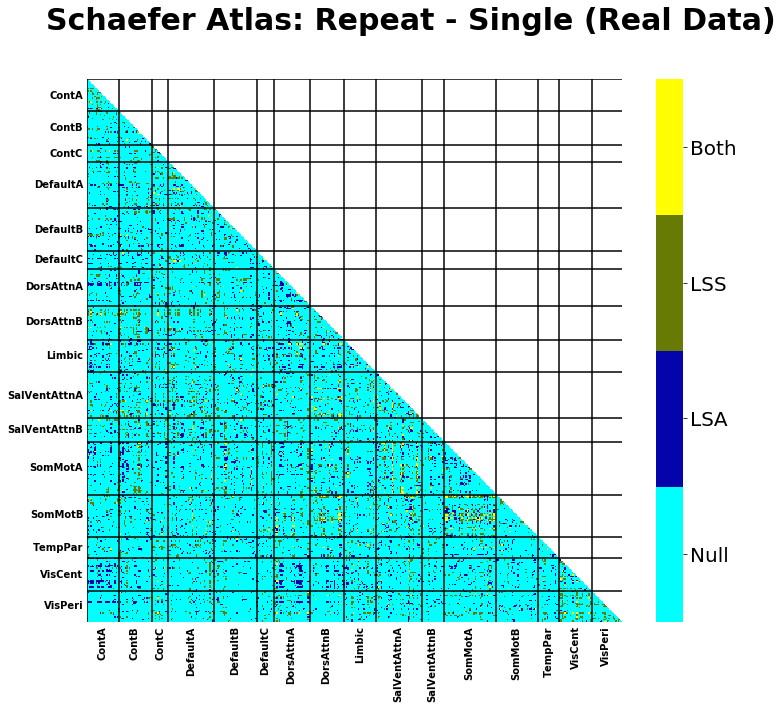

In [123]:
fig, lss_model_df1, lsa_model_df1, overlap_df1 = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['repeat'][:20],
                       ts_sch_lss_objs['single'][:20],
                       ts_sch_lsa_objs['repeat'][:20],
                       ts_sch_lsa_objs['single'][:20],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

Number of Positives lsa: 6663 / 79800
Number of Positives lss: 6268 / 79800
Number of overlapping positives: 1015 / 79800


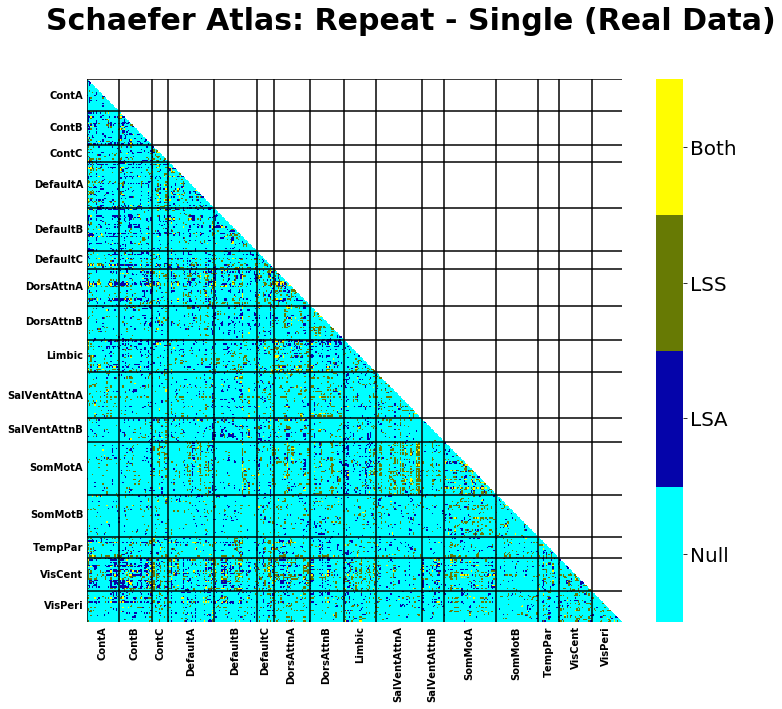

In [124]:
fig, lss_model_df2, lsa_model_df2, overlap_df2 = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['repeat'][20:],
                       ts_sch_lss_objs['single'][20:],
                       ts_sch_lsa_objs['repeat'][20:],
                       ts_sch_lsa_objs['single'][20:],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [125]:
sig1 = (lsa_model_df1['p_value'] < 0.05)
sig2 = (lsa_model_df2['p_value'] < 0.05)
dice_coef = 2 * (sig1 & sig2).sum() / (sig1.sum() + sig2.sum()) 
dice_coef

0.11243527574586998

In [126]:
sig1 = (lss_model_df1['p_value'] < 0.05)
sig2 = (lss_model_df2['p_value'] < 0.05)
dice_coef = 2 * (sig1 & sig2).sum() / (sig1.sum() + sig2.sum()) 
dice_coef

0.08625477264838598

Number of Positives lsa: 9145 / 79800
Number of Positives lss: 7631 / 79800
Number of overlapping positives: 1608 / 79800


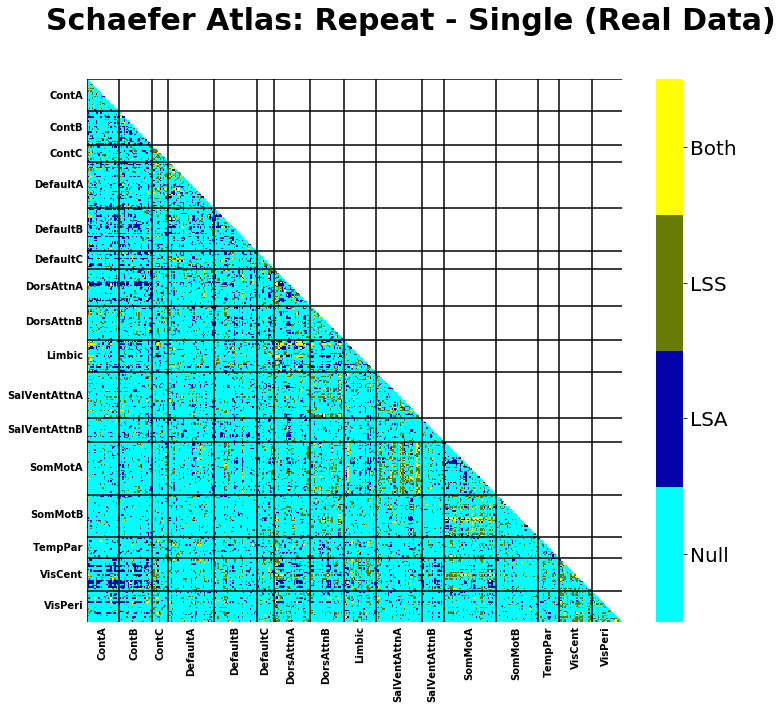

In [127]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['repeat'],
                       ts_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

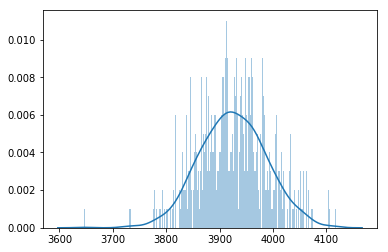

In [128]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_sch_lss_objs['repeat'], ts_sch_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [129]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

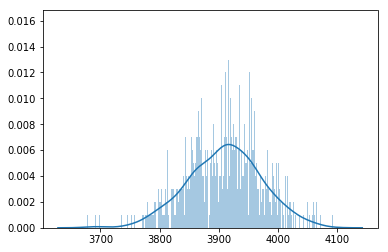

In [130]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_sch_lsa_objs['repeat'], ts_sch_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [131]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [132]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1) // 2

42

In [133]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2) // 2

36

In [134]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3) // 2

6

0.0

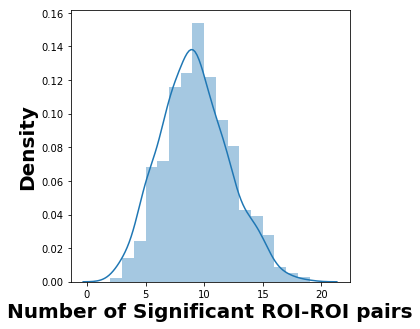

In [135]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['repeat'], 'repeat', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lss_objs['single'], 'single', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [136]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

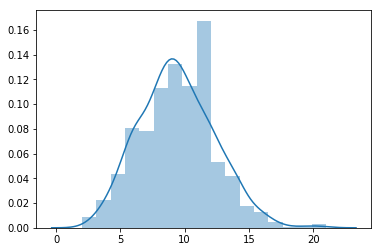

In [137]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lsa_objs['repeat'], 'repeat', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lsa_objs['single'], 'single', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))

bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [138]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [139]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(3,)

In [140]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: repeat - single (null)

Number of Positives lsa: 6762 / 79800
Number of Positives lss: 8461 / 79800
Number of overlapping positives: 1803 / 79800


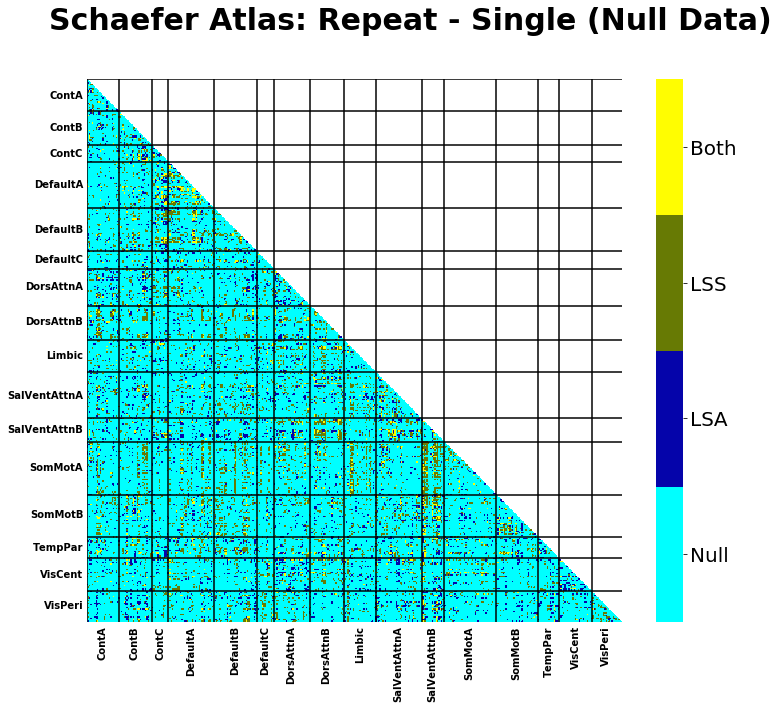

In [141]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['repeat'],
                       fb_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

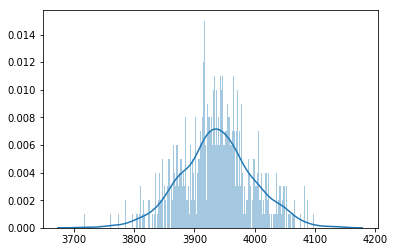

In [142]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_sch_lss_objs['repeat'], fb_sch_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [143]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

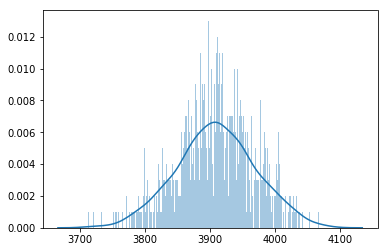

In [144]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_sch_lsa_objs['repeat'], fb_sch_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [145]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [146]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

48

In [147]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

18

In [148]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

0.601

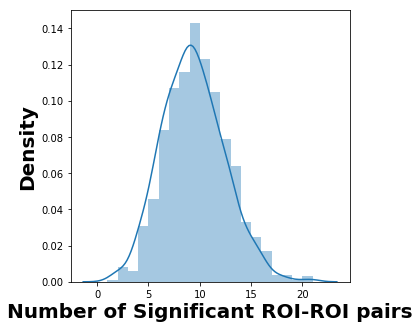

In [149]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lss_objs['repeat'], 'repeat', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lss_objs['single'], 'single', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [150]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

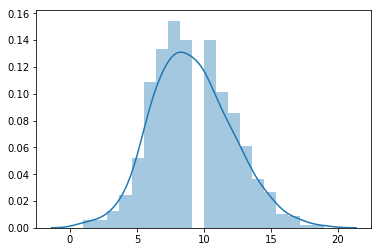

In [151]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lsa_objs['repeat'], 'repeat', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lsa_objs['single'], 'single', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [152]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [153]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [154]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(2,)

### Activation Atlas: repeat - single (task)

Number of Positives lsa: 21 / 210
Number of Positives lss: 16 / 210
Number of overlapping positives: 3 / 210


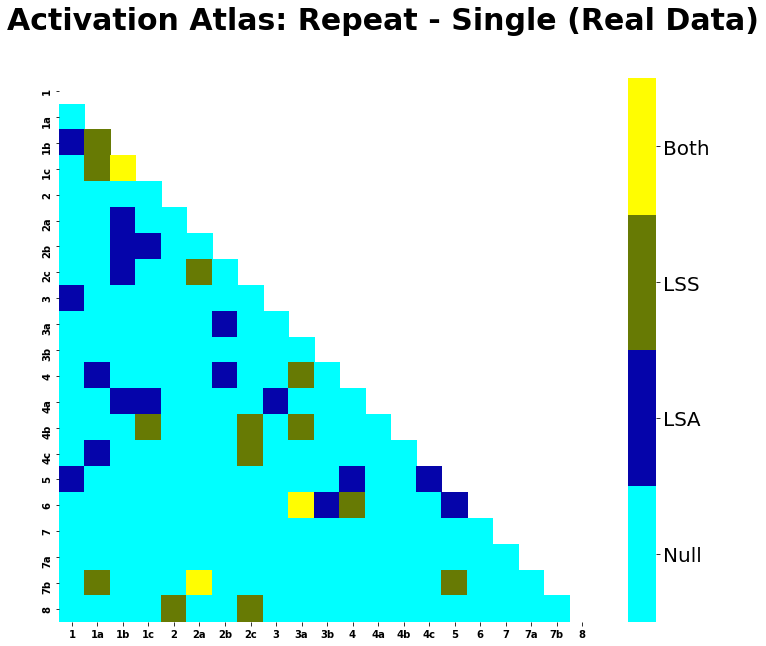

In [155]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['repeat'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['repeat'],
                       ts_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-repeatXsingle'
save_eps(fig, outfile)

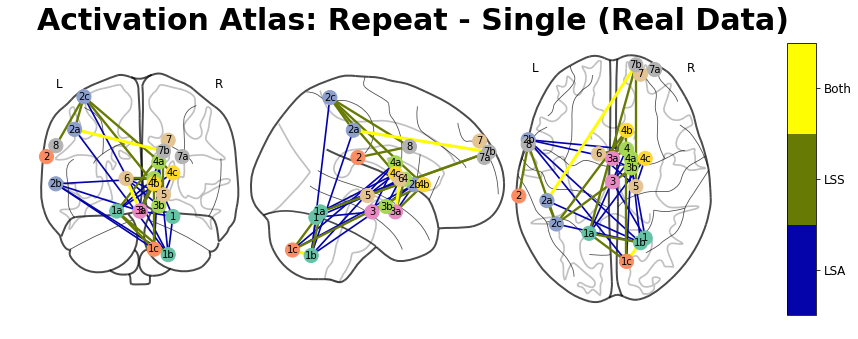

In [156]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-repeatXsingle'
save_eps(fig, outfile)

In [157]:
fig.suptitle("")
save_eps(fig, outfile + '_separate')

0.047

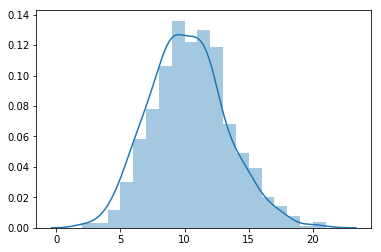

In [158]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['repeat'], ts_act_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [159]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.005

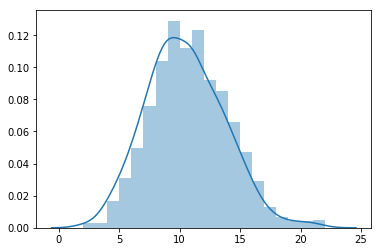

In [160]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['repeat'], ts_act_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [161]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [162]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [163]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: repeat - single (null)

Number of Positives lsa: 10 / 210
Number of Positives lss: 12 / 210
Number of overlapping positives: 1 / 210


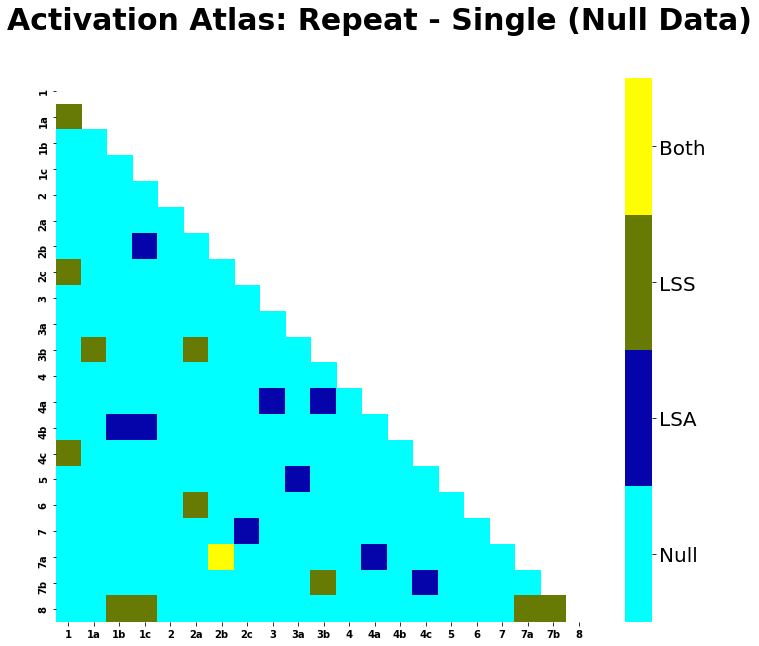

In [164]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['repeat'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['repeat'],
                       fb_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

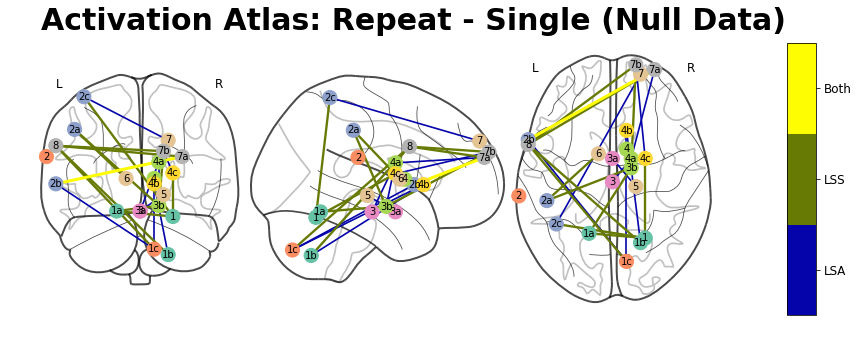

In [165]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-repeatXsingle.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.331

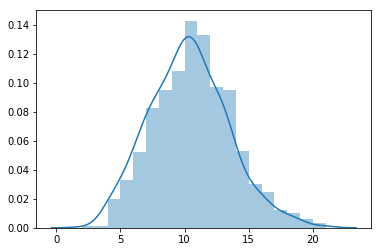

In [166]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['repeat'], fb_act_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [167]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.58

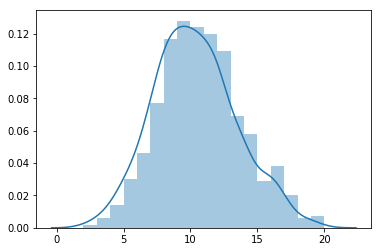

In [168]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['repeat'], fb_act_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [169]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [170]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [171]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: switch - repeat (task)

Number of Positives lsa: 5153 / 79800
Number of Positives lss: 3462 / 79800
Number of overlapping positives: 397 / 79800


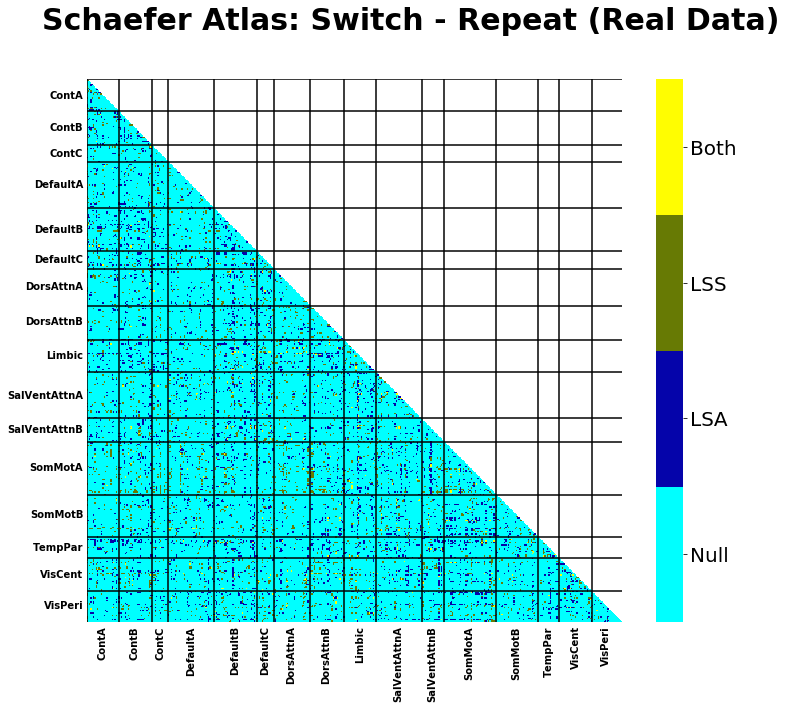

In [172]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lsa_objs['switch'],
                       ts_sch_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchXrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

Number of Positives lsa: 4557 / 79800
Number of Positives lss: 3125 / 79800
Number of overlapping positives: 371 / 79800


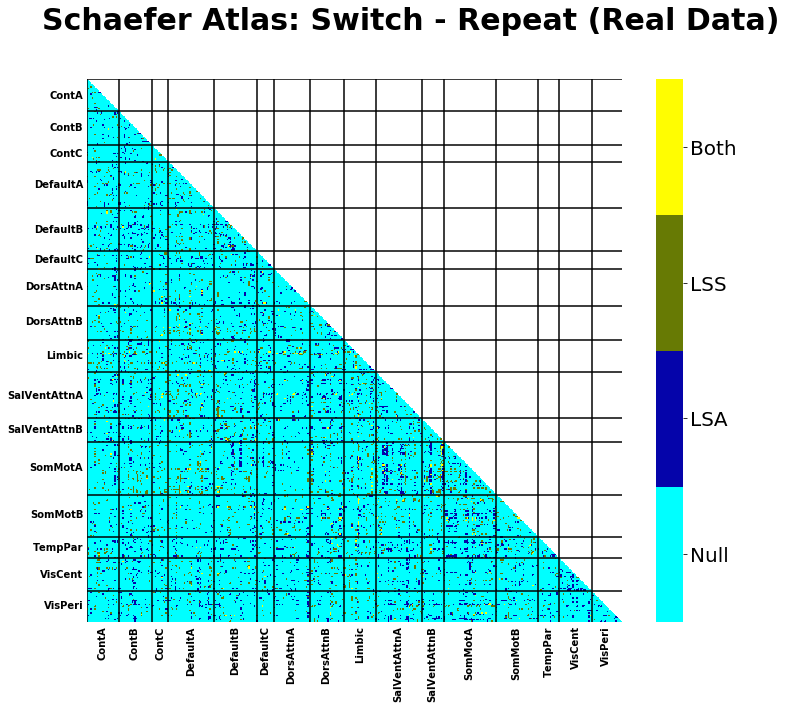

In [173]:
fig, lss_model_df1, lsa_model_df1, overlap_df1 = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'][:20],
                       ts_sch_lss_objs['repeat'][:20],
                       ts_sch_lsa_objs['switch'][:20],
                       ts_sch_lsa_objs['repeat'][:20],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchXrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

Number of Positives lsa: 3974 / 79800
Number of Positives lss: 3346 / 79800
Number of overlapping positives: 294 / 79800


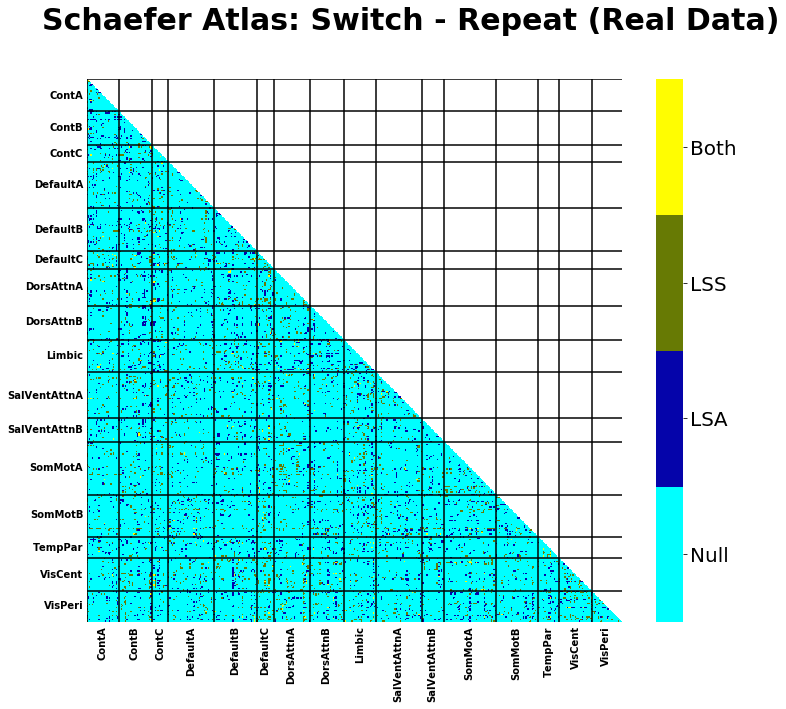

In [174]:
fig, lss_model_df2, lsa_model_df2, overlap_df2 = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'][20:],
                       ts_sch_lss_objs['repeat'][20:],
                       ts_sch_lsa_objs['switch'][20:],
                       ts_sch_lsa_objs['repeat'][20:],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchXrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [175]:
((lsa_model_df1['p_value'] < 0.05) & (lsa_model_df2['p_value'] < 0.05)).sum()

197

In [176]:
((lss_model_df1['p_value'] < 0.05) & (lss_model_df2['p_value'] < 0.05)).sum()

128

1.0

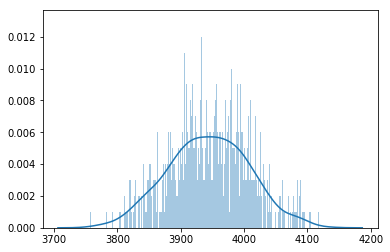

In [177]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_sch_lss_objs['switch'], ts_sch_lss_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [178]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

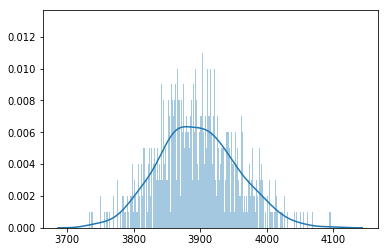

In [179]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-real_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['switch'], ts_act_lsa_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [180]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [181]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

16

In [182]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

16

In [183]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

0.698

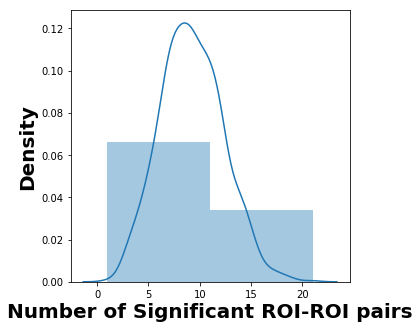

In [184]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lss_objs['switch'], 'switch', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lss_objs['repeat'], 'repeat', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lss_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [185]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.7

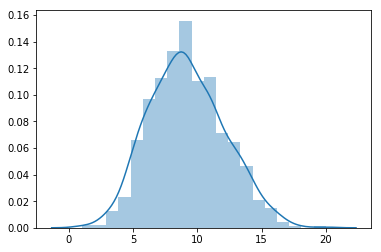

In [186]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-real_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(ts_sch_lsa_objs['switch'], 'switch', list(best_regions_orig)),
                         nf.bind_matrices(ts_sch_lsa_objs['repeat'], 'repeat', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=(max(lss_perm) - min(lss_perm)))
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [187]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [188]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [189]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Schaefer Atlas: switch - repeat (null)

Number of Positives lsa: 3904 / 79800
Number of Positives lss: 4443 / 79800
Number of overlapping positives: 421 / 79800


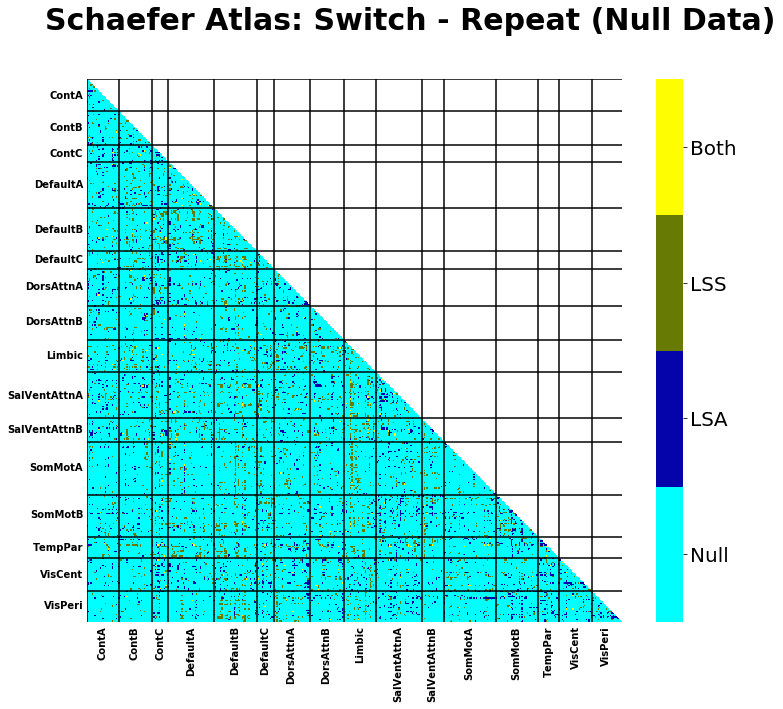

In [190]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['switch'],
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-switchXrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.0

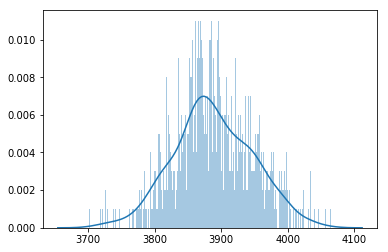

In [191]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_sch_lss_objs['switch'], fb_sch_lss_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [192]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.541

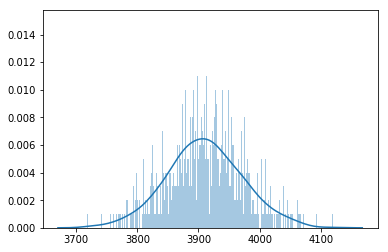

In [193]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-null_atlas-schaefer_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_sch_lsa_objs['switch'], fb_sch_lsa_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [194]:
permutation_collector['atlas'].append('schaefer')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [195]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

60

In [196]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

12

In [197]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

0

In [198]:
bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
np.sum(lsa_model_df['p_value'][bool_query] < 0.05)

30

0.906

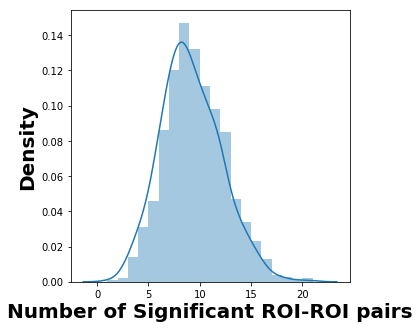

In [199]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lss_objs['switch'], 'switch', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lss_objs['repeat'], 'repeat', list(best_regions_orig))])
    lss_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)

fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(lss_perm, bins=(max(lss_perm) - min(lss_perm)), ax=ax)
ax.set_xlabel("Number of Significant ROI-ROI pairs", fontdict={'weight': 'heavy', 'size': 20})
ax.set_ylabel("Density", fontdict={'weight': 'heavy', 'size': 20})

# calculate intermediate values
bool_query = lss_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
num_sig = np.sum(lss_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)

permutation_pvalue

In [200]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.0

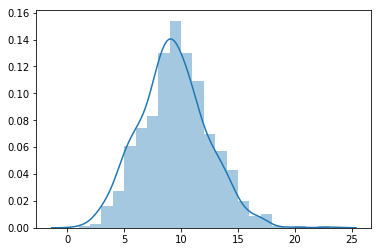

In [202]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-null_atlas-schaeferbest_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    wide_df = pd.concat([nf.bind_matrices(fb_sch_lsa_objs['switch'], 'switch', list(best_regions_orig)),
                         nf.bind_matrices(fb_sch_lsa_objs['repeat'], 'repeat', list(best_regions_orig))])
    lsa_perm = nf.count_positives_from_permutations(
        wide_df=wide_df, nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)

bool_query = lsa_model_df['source'].isin(best_regions_orig) & lsa_model_df['target'].isin(best_regions_orig)
sns.distplot(lsa_perm, bins=(max(lsa_perm) - min(lsa_perm)))
num_sig = np.sum(lsa_model_df['p_value'][bool_query] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [203]:
permutation_collector['atlas'].append('schaeferbest')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [204]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [205]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: switch - repeat (task)

Number of Positives lsa: 15 / 210
Number of Positives lss: 6 / 210
Number of overlapping positives: 1 / 210


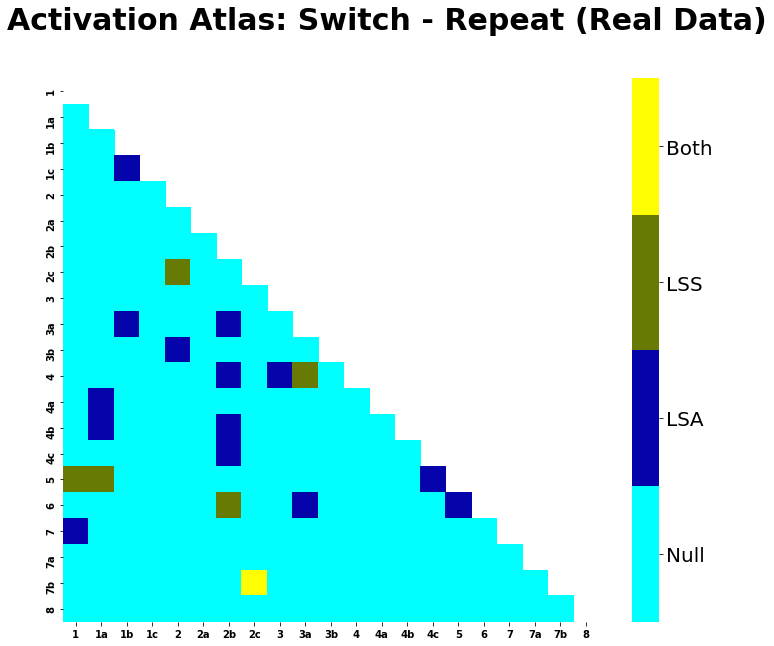

In [206]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       ts_act_lss_objs['repeat'],
                       ts_act_lsa_objs['switch'],
                       ts_act_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-switchXrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

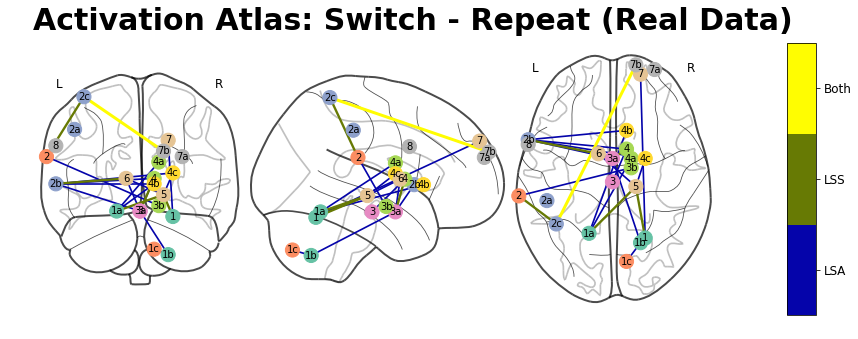

In [207]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-switchXrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.958

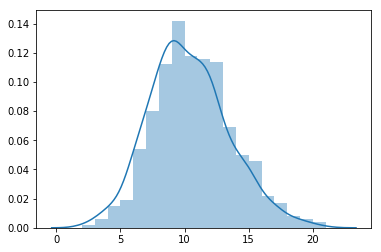

In [208]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['switch'], ts_act_lss_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [209]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.102

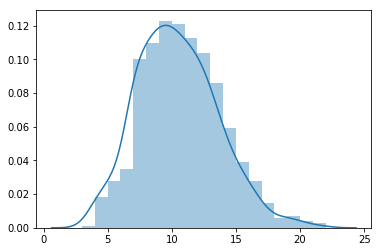

In [210]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-real_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['switch'], ts_act_lsa_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [211]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [212]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [213]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

### Activation Atlas: switch - repeat (null)

Number of Positives lsa: 12 / 210
Number of Positives lss: 3 / 210
Number of overlapping positives: 1 / 210


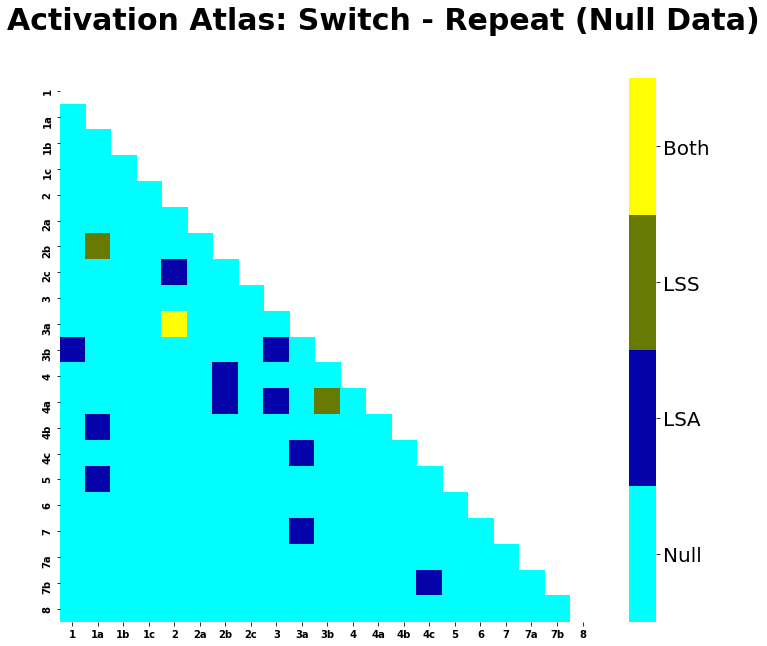

In [214]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['switch'],
                       fb_act_lss_objs['repeat'],
                       fb_act_lsa_objs['switch'],
                       fb_act_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-switchXrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

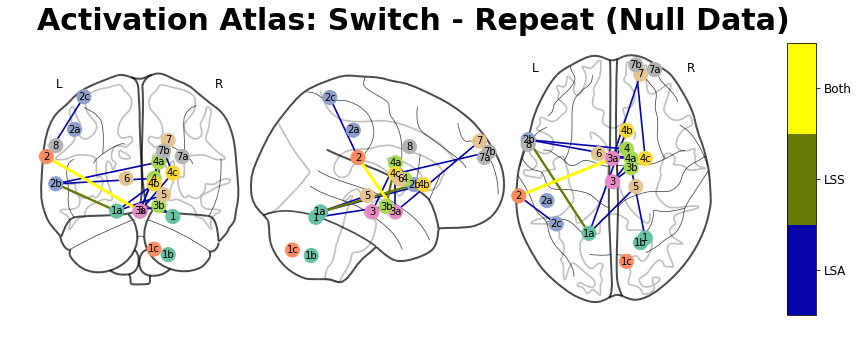

In [215]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-switchXrepeat.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

0.99

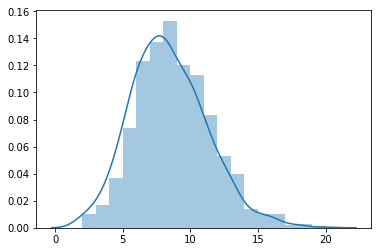

In [216]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['switch'], fb_act_lss_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [217]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

0.149

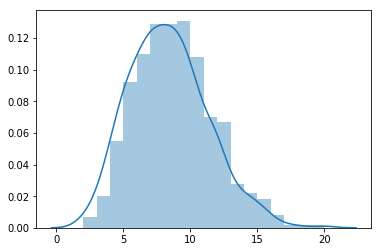

In [219]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-null_atlas-activation_permutations.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['switch'], fb_act_lsa_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [220]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('filtered')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [221]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

(0,)

In [222]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

(0,)

## !!! Same analysis with all participants (not just the "good" ones) !!!

In [ ]:
# fb=fauxbold, ts=taskswitch
# act=activation, sch=schaefer
# lss=least squares separate, lsa=least squares all
fb_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold")

fb_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold")

ts_act_lss_objs = nf.get_layout_objects(lss_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch")

ts_act_lsa_objs = nf.get_layout_objects(lsa_act_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch")

fb_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold")

fb_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="fauxbold")

ts_sch_lss_objs = nf.get_layout_objects(lss_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch")

ts_sch_lsa_objs = nf.get_layout_objects(lsa_sch_layout,
                                        ['switch', 'repeat', 'single'],
                                        suffix="correlation", extension="tsv",
                                        task="taskswitch")

###  Schaefer Atlas: task - null

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       fb_sch_lss_objs['switch'],
                       ts_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['switch'],
                       'task', 'null',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-schaefer_contrast-taskXnull_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSA
np.sum(overlap_df.loc[best_regions,:].values == 1)

In [ ]:
# LSS
np.sum(overlap_df.loc[best_regions,:].values == 2)

In [ ]:
# Overlap
np.sum(overlap_df.loc[best_regions, :].values == 3)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

###  Activation Atlas: task - null

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       fb_act_lss_objs['switch'],
                       ts_act_lsa_objs['switch'],
                       fb_act_lsa_objs['switch'],
                       'task', 'null',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_atlas-activation_contrast-taskXnull.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Task - Null", size=30, weight='heavy')
outfile = './outputs/data-both_type-brain_atlas-activation_contrast-taskXnull_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-taskxnull_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['switch'], fb_act_lss_objs['switch'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [ ]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-taskxnull_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['switch'], fb_act_lsa_objs['switch'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('taskxnull')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_model_df[lss_sig_array])
display(lss_fdr_pvalues[lss_sig_array])

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
lsa_model_df[lsa_sig_array]

LSS has one result that survives FDR correction whereas LSA has no results that survive 

### Schaefer Atlas: switch - single (task)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['switch'],
                       ts_sch_lsa_objs['single'],
                       'switch', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSA
np.sum(overlap_df.loc[best_regions,:].values == 1)

In [ ]:
# LSS
np.sum(overlap_df.loc[best_regions,:].values == 2)

In [ ]:
# Overlap
np.sum(overlap_df.loc[best_regions, :].values == 3)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Schaefer Atlas: switch - single (null)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['switch'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['single'],
                       'switch', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-switchXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

In [ ]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

In [ ]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Activation Atlas: switch - single (task)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['switch'],
                       ts_act_lsa_objs['single'],
                       'switch', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-switchXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-switchXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['switch'], ts_act_lss_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [ ]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['switch'], ts_act_lsa_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Activation Atlas: switch - single (null)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['switch'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['switch'],
                       fb_act_lsa_objs['single'],
                       'switch', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-switchXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-switchXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxsingle_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['switch'], fb_act_lss_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [ ]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxsingle_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['switch'], fb_act_lsa_objs['single'],
        'switch', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Schaefer Atlas: repeat - single (task)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lss_objs['single'],
                       ts_sch_lsa_objs['repeat'],
                       ts_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

In [ ]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

In [ ]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

In [ ]:
# test if FDR correction works for the 50 best regions
query = (lsa_model_df['source'].isin(best_regions_orig)) & (lsa_model_df['target'].isin(best_regions_orig))
lsa_sig_array2, lsa_fdr_pvalues2, _, _ = multipletests(lsa_model_df[query]['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues2[lsa_sig_array2].shape)

In [ ]:
lsa_model_df

### Schaefer Atlas: repeat - single (null)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lss_objs['single'],
                       fb_sch_lsa_objs['repeat'],
                       fb_sch_lsa_objs['single'],
                       'repeat', 'single',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

In [ ]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

In [ ]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Activation Atlas: repeat - single (task)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['repeat'],
                       ts_act_lss_objs['single'],
                       ts_act_lsa_objs['repeat'],
                       ts_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Repeat - Single (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['repeat'], ts_act_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [ ]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['repeat'], ts_act_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Activation Atlas: repeat - single (null)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['repeat'],
                       fb_act_lss_objs['single'],
                       fb_act_lsa_objs['repeat'],
                       fb_act_lsa_objs['single'],
                       'repeat', 'single',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Repeat - Single (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-repeatXsingle_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-repeatxsingle_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['repeat'], fb_act_lss_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [ ]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-repeatxsingle_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['repeat'], fb_act_lsa_objs['single'],
        'repeat', 'single', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('repeatxsingle')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Schaefer Atlas: switch - repeat (task)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_sch_lss_objs['switch'],
                       ts_sch_lss_objs['repeat'],
                       ts_sch_lsa_objs['switch'],
                       ts_sch_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-schaefer_contrast-switchXrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

In [ ]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

In [ ]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Schaefer Atlas: switch - repeat (null)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_sch_lss_objs['switch'],
                       fb_sch_lss_objs['repeat'],
                       fb_sch_lsa_objs['switch'],
                       fb_sch_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='schaefer', nthreads=N_THREADS, use_python=True)
fig.suptitle("Schaefer Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-schaefer_contrast-switchXrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSA
np.sum(overlap_df.loc[best_regions, best_regions].values == 1)

In [ ]:
# LSS
np.sum(overlap_df.loc[best_regions, best_regions].values == 2)

In [ ]:
# Overlap
np.sum(overlap_df.loc[best_regions, best_regions].values == 3)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Activation Atlas: switch - repeat (task)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       ts_act_lss_objs['switch'],
                       ts_act_lss_objs['repeat'],
                       ts_act_lsa_objs['switch'],
                       ts_act_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_atlas-activation_contrast-switchXrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Repeat (Real Data)", size=30, weight='heavy')
outfile = './outputs/data-task_type-brain_atlas-activation_contrast-switchXrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        ts_act_lss_objs['switch'], ts_act_lss_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [ ]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-real_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        ts_act_lsa_objs['switch'], ts_act_lsa_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('real')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Activation Atlas: switch - repeat (null)

In [ ]:
fig, lss_model_df, lsa_model_df, overlap_df = nf.compare_lss_lsa_sig(
                       fb_act_lss_objs['switch'],
                       fb_act_lss_objs['repeat'],
                       fb_act_lsa_objs['switch'],
                       fb_act_lsa_objs['repeat'],
                       'switch', 'repeat',
                       rois='activation', nthreads=N_THREADS, use_python=True)
fig.suptitle("Activation Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_atlas-activation_contrast-switchXrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
fig = nf.make_glass_brain(overlap_df, coords_df)
fig.suptitle("Activation Atlas: Switch - Repeat (Null Data)", size=30, weight='heavy')
outfile = './outputs/data-null_type-brain_atlas-activation_contrast-switchXrepeat_allsub.eps'
fig.savefig(outfile, dpi=600, bbox_inches='tight')

In [ ]:
# LSS
lss_perm_file = './outputs/estimation-lss_contrast-switchxrepeat_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lss_perm_file):
    with open(lss_perm_file, "rb") as pklr:
        lss_perm = pickle.load(pklr)
else:
    lss_perm = nf.count_positives_from_permutations(
        fb_act_lss_objs['switch'], fb_act_lss_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lss_perm_file, "wb") as pklw:
        pickle.dump(lss_perm, pklw)
    
sns.distplot(lss_perm, bins=max(lss_perm) - min(lss_perm))
num_sig = np.sum(lss_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lss_perm) >= num_sig) / len(lss_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lss')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lss_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

In [ ]:
# LSA
lsa_perm_file = './outputs/estimation-lsa_contrast-switchxrepeat_data-null_atlas-activation_permutations_allsub.pkl'
if os.path.isfile(lsa_perm_file):
    with open(lsa_perm_file, "rb") as pklr:
        lsa_perm = pickle.load(pklr)
else:
    lsa_perm = nf.count_positives_from_permutations(
        fb_act_lsa_objs['switch'], fb_act_lsa_objs['repeat'],
        'switch', 'repeat', nthreads=N_THREADS, permutations=1000, use_python=True)
    with open(lsa_perm_file, "wb") as pklw:
        pickle.dump(lsa_perm, pklw)
    
sns.distplot(lsa_perm, bins=max(lsa_perm) - min(lsa_perm))
num_sig = np.sum(lsa_model_df['p_value'] < 0.05)
permutation_pvalue = np.sum(np.array(lsa_perm) >= num_sig) / len(lsa_perm)
permutation_pvalue

In [ ]:
permutation_collector['atlas'].append('activation')
permutation_collector['data'].append('null')
permutation_collector['contrast'].append('switchxrepeat')
permutation_collector['estimator'].append('lsa')
permutation_collector['participants'].append('all')
permutation_collector['permutations'].append(lsa_perm)
permutation_collector['observed_value'].append(num_sig)
permutation_collector['p_value'].append(permutation_pvalue)

### Test significance of pairs of correlations

In [ ]:
lss_sig_array, lss_fdr_pvalues, _, _ = multipletests(lss_model_df['p_value'], method='fdr_bh')
display(lss_fdr_pvalues[lss_sig_array].shape)

In [ ]:
lsa_sig_array, lsa_fdr_pvalues, _, _ = multipletests(lsa_model_df['p_value'], method='fdr_bh')
display(lsa_fdr_pvalues[lsa_sig_array].shape)

### Permutation Analysis

In [226]:
permutation_df = pd.DataFrame.from_dict(permutation_collector)
permutation_df.to_csv('./outputs/permutation_results.tsv', sep='\t')

In [269]:
permutation_df.query('atlas == "schaeferbest"')

atlas  data       contrast estimator participants  \
2   schaeferbest  real      taskxnull       lss     filtered   
3   schaeferbest  real      taskxnull       lsa     filtered   
8   schaeferbest  real  switchxsingle       lss     filtered   
9   schaeferbest  real  switchxsingle       lsa     filtered   
12  schaeferbest  null  switchxsingle       lss     filtered   
13  schaeferbest  null  switchxsingle       lsa     filtered   
20  schaeferbest  real  repeatxsingle       lss     filtered   
21  schaeferbest  real  repeatxsingle       lsa     filtered   
24  schaeferbest  null  repeatxsingle       lss     filtered   
25  schaeferbest  null  repeatxsingle       lsa     filtered   
32  schaeferbest  real  switchxrepeat       lss     filtered   
33  schaeferbest  real  switchxrepeat       lsa     filtered   
36  schaeferbest  null  switchxrepeat       lss     filtered   
37  schaeferbest  null  switchxrepeat       lsa     filtered   

                                         permutations  observed_value  p_value  
2   [11, 14, 14, 8, 11, 5, 14, 9, 11, 17, 11, 13, ...              27    0.000  
3   [8, 10, 13, 9, 17, 7, 12, 10, 6, 7, 10, 6, 13,...              29    0.000  
8   [6, 7, 11, 10, 10, 7, 6, 7, 11, 11, 8, 15, 14,...               9    0.577  
9   [9, 11, 7, 12, 7, 10, 7, 10, 12, 12, 10, 12, 1...              18    0.010  
12  [10, 8, 7, 6, 8, 12, 7, 8, 12, 6, 5, 5, 5, 6, ...               8    0.708  
13  [7, 7, 9, 10, 11, 10, 9, 9, 12, 11, 13, 6, 9, ...              13    0.144  
20  [4, 6, 12, 9, 12, 6, 9, 7, 8, 10, 5, 18, 10, 9...              21    0.000  
21  [9, 13, 8, 15, 11, 12, 8, 10, 12, 11, 8, 10, 1...              24    0.000  
24  [5, 9, 8, 10, 8, 9, 13, 7, 9, 8, 6, 10, 12, 12...               9    0.601  
25  [8, 13, 12, 9, 5, 11, 7, 7, 6, 6, 6, 10, 8, 7,...              24    0.000  
32  [12, 7, 6, 12, 3, 10, 7, 12, 6, 7, 14, 11, 8, ...               8    0.698  
33  [11, 7, 12, 12, 7, 6, 11, 8, 6, 10, 9, 8, 7, 1...               8    0.700  
36  [10, 7, 7, 7, 6, 12, 12, 9, 9, 16, 6, 6, 10, 8...               6    0.906  
37  [5, 6, 9, 10, 10, 12, 9, 13, 10, 9, 9, 11, 6, ...              30    0.000

In [270]:
# https://stackoverflow.com/questions/27263805/pandas-column-of-lists-create-a-row-for-each-list-element
lst_col = 'permutations'

permutation_long_df = pd.DataFrame({
      col:np.repeat(permutation_df[col].values, permutation_df[lst_col].str.len())
      for col in permutation_df.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(permutation_df[lst_col].values)})[permutation_df.columns]
permutation_long_df.shape

(42000, 8)

## Activation Atlas Real Data

In [328]:
permutation_long_filt_df = permutation_long_df.query("(participants == 'filtered') & (data == 'real') & (atlas == 'activation')")
permutation_long_filt_df

atlas  data       contrast estimator participants  permutations  \
4000   activation  real      taskxnull       lss     filtered            13   
4001   activation  real      taskxnull       lss     filtered             9   
4002   activation  real      taskxnull       lss     filtered             9   
4003   activation  real      taskxnull       lss     filtered             7   
4004   activation  real      taskxnull       lss     filtered            15   
4005   activation  real      taskxnull       lss     filtered            12   
4006   activation  real      taskxnull       lss     filtered            15   
4007   activation  real      taskxnull       lss     filtered            12   
4008   activation  real      taskxnull       lss     filtered            10   
4009   activation  real      taskxnull       lss     filtered            10   
4010   activation  real      taskxnull       lss     filtered            13   
4011   activation  real      taskxnull       lss     filtered            13   
4012   activation  real      taskxnull       lss     filtered            12   
4013   activation  real      taskxnull       lss     filtered            13   
4014   activation  real      taskxnull       lss     filtered            12   
4015   activation  real      taskxnull       lss     filtered             6   
4016   activation  real      taskxnull       lss     filtered            11   
4017   activation  real      taskxnull       lss     filtered             9   
4018   activation  real      taskxnull       lss     filtered            10   
4019   activation  real      taskxnull       lss     filtered            10   
4020   activation  real      taskxnull       lss     filtered             5   
4021   activation  real      taskxnull       lss     filtered            17   
4022   activation  real      taskxnull       lss     filtered            10   
4023   activation  real      taskxnull       lss     filtered             9   
4024   activation  real      taskxnull       lss     filtered             9   
4025   activation  real      taskxnull       lss     filtered             7   
4026   activation  real      taskxnull       lss     filtered            11   
4027   activation  real      taskxnull       lss     filtered            12   
4028   activation  real      taskxnull       lss     filtered            12   
4029   activation  real      taskxnull       lss     filtered             4   
...           ...   ...            ...       ...          ...           ...   
39970  activation  real  switchxrepeat       lsa     filtered            12   
39971  activation  real  switchxrepeat       lsa     filtered            11   
39972  activation  real  switchxrepeat       lsa     filtered            10   
39973  activation  real  switchxrepeat       lsa     filtered             8   
39974  activation  real  switchxrepeat       lsa     filtered            10   
39975  activation  real  switchxrepeat       lsa     filtered            10   
39976  activation  real  switchxrepeat       lsa     filtered            12   
39977  activation  real  switchxrepeat       lsa     filtered            10   
39978  activation  real  switchxrepeat       lsa     filtered            12   
39979  activation  real  switchxrepeat       lsa     filtered            14   
39980  activation  real  switchxrepeat       lsa     filtered             9   
39981  activation  real  switchxrepeat       lsa     filtered            12   
39982  activation  real  switchxrepeat       lsa     filtered            13   
39983  activation  real  switchxrepeat       lsa     filtered            11   
39984  activation  real  switchxrepeat       lsa     filtered            11   
39985  activation  real  switchxrepeat       lsa     filtered            12   
39986  activation  real  switchxrepeat       lsa     filtered             9   
39987  activation  real  switchxrepeat       lsa     filtered             7   
39988  activation  real  switchxrepeat       lsa     filtered 

In [329]:
permutation_long_filt_df['observed_value_percent'] = (permutation_long_filt_df['observed_value'] / 210) * 100
permutation_long_filt_df['permutations_percent'] = (permutation_long_filt_df['permutations'] / 210) * 100

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


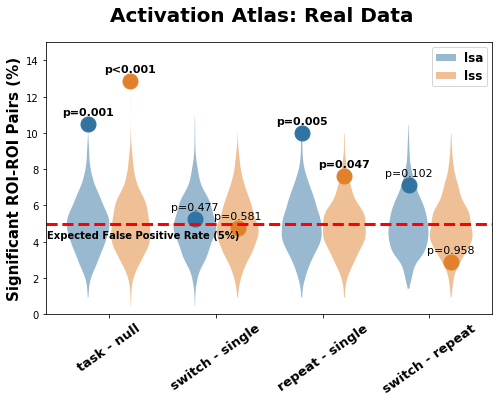

In [330]:
alpha = 0.5
contrast_order = ['taskxnull', 'switchxsingle', 'repeatxsingle', 'switchxrepeat']
method_order = ['lsa', 'lss']
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(x='contrast', y='permutations_percent', hue='estimator',
               inner=None, order=contrast_order, hue_order=method_order, cut=0, ax=ax, linewidth=0,
               data=permutation_long_filt_df)

ax.set_ylim(0, 15)

# change the alpha of the violins
contrast_orders = [item for item in contrast_order for i in range(2)]
method_orders = method_order * 4

for contrast, method, poly in zip(contrast_orders, method_orders, ax.collections):
    poly.set_alpha(alpha)
    
    df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
    p_val = permutation_long_filt_df.query(df_query)['p_value'].unique()[0]
    ov = permutation_long_filt_df.query(df_query)['observed_value_percent'].unique()[0]
    # get x coordinate for dot
    x_coord = poly.get_paths()[0].vertices[0, 0]
    
    # get color for dot
    color = poly.get_facecolor().flatten()
    
    # change the alpha to 1
    color[-1] = 1
    ax.plot(x_coord, ov, 'bo', markersize=15, color=color)
    
    # add text to display each p-value
    # p-values can't actually be zero
    if p_val == 0.0:
        p_str = 'p<' + str(p_val + 0.001)
    else:
        p_str = 'p=' + str(p_val)
    
    # bold significant p-value
    if p_val < 0.05:
        weight = 'bold'
    else:
        weight = 'normal'
    ax.text(x_coord, ov+.5, p_str, ha='center', size=11, weight=weight)
    
# set y label
ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)
    
# set x label
ax.set_xlabel("")

# set x tick marks
new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

# change the alpha of the legend, and make text more visible
[p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
ax.legend_.set_title("")
ax.legend_.texts[0].set(size=12, weight='bold')

# draw false positive line
ax.axhline(5, color='red', linestyle='--', linewidth=3)
ax.text(ax.get_xlim()[0] + 0.01, 4.2, "Expected False Positive Rate (5%)", weight='heavy');

# make title
fig.suptitle("Activation Atlas: Real Data", size=20, weight="heavy")

# save the figure
save_eps(fig, './outputs/data-real_atlas-activation_participants-filtered_permutation_summary')

## Activation Atlas Null Data

In [331]:
permutation_long_filt_df = permutation_long_df.query("(participants == 'filtered') & (data == 'null') & (atlas == 'activation')")
permutation_long_filt_df

atlas  data       contrast estimator participants  permutations  \
16000  activation  null  switchxsingle       lss     filtered            10   
16001  activation  null  switchxsingle       lss     filtered            13   
16002  activation  null  switchxsingle       lss     filtered            12   
16003  activation  null  switchxsingle       lss     filtered             7   
16004  activation  null  switchxsingle       lss     filtered             9   
16005  activation  null  switchxsingle       lss     filtered             7   
16006  activation  null  switchxsingle       lss     filtered            10   
16007  activation  null  switchxsingle       lss     filtered            11   
16008  activation  null  switchxsingle       lss     filtered             7   
16009  activation  null  switchxsingle       lss     filtered            12   
16010  activation  null  switchxsingle       lss     filtered            18   
16011  activation  null  switchxsingle       lss     filtered            10   
16012  activation  null  switchxsingle       lss     filtered             9   
16013  activation  null  switchxsingle       lss     filtered            12   
16014  activation  null  switchxsingle       lss     filtered             8   
16015  activation  null  switchxsingle       lss     filtered             7   
16016  activation  null  switchxsingle       lss     filtered            14   
16017  activation  null  switchxsingle       lss     filtered             7   
16018  activation  null  switchxsingle       lss     filtered            11   
16019  activation  null  switchxsingle       lss     filtered             7   
16020  activation  null  switchxsingle       lss     filtered             6   
16021  activation  null  switchxsingle       lss     filtered             7   
16022  activation  null  switchxsingle       lss     filtered             9   
16023  activation  null  switchxsingle       lss     filtered            10   
16024  activation  null  switchxsingle       lss     filtered            13   
16025  activation  null  switchxsingle       lss     filtered            10   
16026  activation  null  switchxsingle       lss     filtered             9   
16027  activation  null  switchxsingle       lss     filtered            19   
16028  activation  null  switchxsingle       lss     filtered            12   
16029  activation  null  switchxsingle       lss     filtered            13   
...           ...   ...            ...       ...          ...           ...   
41970  activation  null  switchxrepeat       lsa     filtered             4   
41971  activation  null  switchxrepeat       lsa     filtered             4   
41972  activation  null  switchxrepeat       lsa     filtered             8   
41973  activation  null  switchxrepeat       lsa     filtered             7   
41974  activation  null  switchxrepeat       lsa     filtered            12   
41975  activation  null  switchxrepeat       lsa     filtered             5   
41976  activation  null  switchxrepeat       lsa     filtered            11   
41977  activation  null  switchxrepeat       lsa     filtered             9   
41978  activation  null  switchxrepeat       lsa     filtered            12   
41979  activation  null  switchxrepeat       lsa     filtered             4   
41980  activation  null  switchxrepeat       lsa     filtered            11   
41981  activation  null  switchxrepeat       lsa     filtered            16   
41982  activation  null  switchxrepeat       lsa     filtered             8   
41983  activation  null  switchxrepeat       lsa     filtered             8   
41984  activation  null  switchxrepeat       lsa     filtered             9   
41985  activation  null  switchxrepeat       lsa     filtered             5   
41986  activation  null  switchxrepeat       lsa     filtered            10   
41987  activation  null  switchxrepeat       lsa     filtered             9   
41988  activation  null  switchxrepeat       lsa     filtered 

In [332]:
permutation_long_filt_df['observed_value_percent'] = (permutation_long_filt_df['observed_value'] / 210) * 100
permutation_long_filt_df['permutations_percent'] = (permutation_long_filt_df['permutations'] / 210) * 100

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


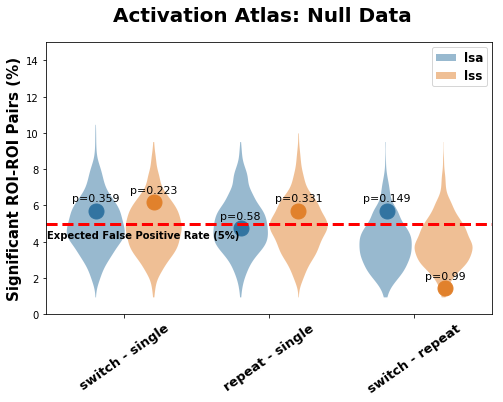

In [333]:
alpha = 0.5
contrast_order = ['switchxsingle', 'repeatxsingle', 'switchxrepeat']
method_order = ['lsa', 'lss']
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(x='contrast', y='permutations_percent', hue='estimator',
               inner=None, order=contrast_order, hue_order=method_order, cut=0, ax=ax, linewidth=0,
               data=permutation_long_filt_df)

ax.set_ylim(0, 15)

# change the alpha of the violins
contrast_orders = [item for item in contrast_order for i in range(2)]
method_orders = method_order * 4

for contrast, method, poly in zip(contrast_orders, method_orders, ax.collections):
    poly.set_alpha(alpha)
    
    df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
    p_val = permutation_long_filt_df.query(df_query)['p_value'].unique()[0]
    ov = permutation_long_filt_df.query(df_query)['observed_value_percent'].unique()[0]
    # get x coordinate for dot
    x_coord = poly.get_paths()[0].vertices[0, 0]
    
    # get color for dot
    color = poly.get_facecolor().flatten()
    
    # change the alpha to 1
    color[-1] = 1
    ax.plot(x_coord, ov, 'bo', markersize=15, color=color)
    
    # add text to display each p-value
    # p-values can't actually be zero
    if p_val == 0.0:
        p_str = 'p<' + str(p_val + 0.001)
    else:
        p_str = 'p=' + str(p_val)
    
    # bold significant p-value
    if p_val < 0.05:
        weight = 'bold'
    else:
        weight = 'normal'
    ax.text(x_coord, ov+.5, p_str, ha='center', size=11, weight=weight)
    
# set y label
ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)
    
# set x label
ax.set_xlabel("")

# set x tick marks
new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

# change the alpha of the legend, and make text more visible
[p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
ax.legend_.set_title("")
ax.legend_.texts[0].set(size=12, weight='bold')

# draw false positive line
ax.axhline(5, color='red', linestyle='--', linewidth=3)
ax.text(ax.get_xlim()[0] + 0.01, 4.2, "Expected False Positive Rate (5%)", weight='heavy');

# make title
fig.suptitle("Activation Atlas: Null Data", size=20, weight="heavy")

# save the figure
save_eps(fig, './outputs/data-null_atlas-activation_participants-filtered_permutation_summary')

## Schaefer Atlas Real Data

In [334]:
permutation_schaefer_long_filt_df = permutation_long_df.query("(participants == 'filtered') & (data == 'real') & (atlas == 'schaefer')")
permutation_schaefer_long_filt_df.head()

atlas  data   contrast estimator participants  permutations  \
0  schaefer  real  taskxnull       lss     filtered          3940   
1  schaefer  real  taskxnull       lss     filtered          3912   
2  schaefer  real  taskxnull       lss     filtered          3906   
3  schaefer  real  taskxnull       lss     filtered          3996   
4  schaefer  real  taskxnull       lss     filtered          4007   

   observed_value  p_value  
0           13736      0.0  
1           13736      0.0  
2           13736      0.0  
3           13736      0.0  
4           13736      0.0

In [335]:
permutation_schaefer_long_filt_df['observed_value_percent'] = (permutation_schaefer_long_filt_df['observed_value'] / 79800) * 100
permutation_schaefer_long_filt_df['permutations_percent'] = (permutation_schaefer_long_filt_df['permutations'] / 79800) * 100

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


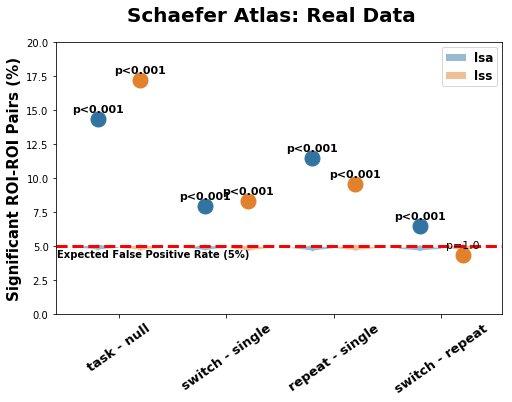

In [336]:
alpha = 0.5
contrast_order = ['taskxnull', 'switchxsingle', 'repeatxsingle', 'switchxrepeat']
method_order = ['lsa', 'lss']
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(x='contrast', y='permutations_percent', hue='estimator',
               inner=None, order=contrast_order, hue_order=method_order, cut=0, ax=ax, linewidth=0,
               data=permutation_schaefer_long_filt_df)

ax.set_ylim(0, 20)

# change the alpha of the violins
contrast_orders = [item for item in contrast_order for i in range(2)]
method_orders = method_order * 4

for contrast, method, poly in zip(contrast_orders, method_orders, ax.collections):
    poly.set_alpha(alpha)
    
    df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
    p_val = permutation_schaefer_long_filt_df.query(df_query)['p_value'].unique()[0]
    ov = permutation_schaefer_long_filt_df.query(df_query)['observed_value_percent'].unique()[0]
    # get x coordinate for dot
    x_coord = poly.get_paths()[0].vertices[0, 0]
    
    # get color for dot
    color = poly.get_facecolor().flatten()
    
    # change the alpha to 1
    color[-1] = 1
    ax.plot(x_coord, ov, 'bo', markersize=15, color=color)
    
    # add text to display each p-value
    # p-values can't actually be zero
    if p_val == 0.0:
        p_str = 'p<' + str(p_val + 0.001)
    else:
        p_str = 'p=' + str(p_val)
    
    # bold significant p-value
    if p_val < 0.05:
        weight = 'bold'
    else:
        weight = 'normal'
    ax.text(x_coord, ov+.5, p_str, ha='center', size=11, weight=weight)
    
# set y label
ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)
    
# set x label
ax.set_xlabel("")

# set x tick marks
new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

# change the alpha of the legend, and make text more visible
[p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
ax.legend_.set_title("")
ax.legend_.texts[0].set(size=12, weight='bold')

# draw false positive line
ax.axhline(5, color='red', linestyle='--', linewidth=3)
ax.text(ax.get_xlim()[0] + 0.01, 4.2, "Expected False Positive Rate (5%)", weight='heavy');

# make title
fig.suptitle("Schaefer Atlas: Real Data", size=20, weight="heavy")

# save the figure
save_eps(fig, './outputs/data-real_atlas-schaefer_participants-filtered_permutation_summary')

## Schaefer Atlas Null Data

In [337]:
permutation_schaefer_long_filt_df = permutation_long_df.query("(participants == 'filtered') & (data == 'null') & (atlas == 'schaefer')")
permutation_schaefer_long_filt_df.head()

atlas  data       contrast estimator participants  permutations  \
10000  schaefer  null  switchxsingle       lss     filtered          3853   
10001  schaefer  null  switchxsingle       lss     filtered          4019   
10002  schaefer  null  switchxsingle       lss     filtered          3981   
10003  schaefer  null  switchxsingle       lss     filtered          4020   
10004  schaefer  null  switchxsingle       lss     filtered          3974   

       observed_value  p_value  
10000            5101      0.0  
10001            5101      0.0  
10002            5101      0.0  
10003            5101      0.0  
10004            5101      0.0

In [338]:
permutation_schaefer_long_filt_df['observed_value_percent'] = (permutation_schaefer_long_filt_df['observed_value'] / 79800) * 100
permutation_schaefer_long_filt_df['permutations_percent'] = (permutation_schaefer_long_filt_df['permutations'] / 79800) * 100

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


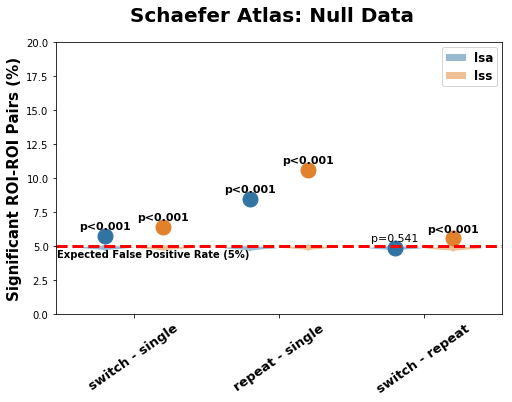

In [339]:
alpha = 0.5
contrast_order = ['switchxsingle', 'repeatxsingle', 'switchxrepeat']
method_order = ['lsa', 'lss']
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(x='contrast', y='permutations_percent', hue='estimator',
               inner=None, order=contrast_order, hue_order=method_order, cut=0, ax=ax, linewidth=0,
               data=permutation_schaefer_long_filt_df)

ax.set_ylim(0, 20)

# change the alpha of the violins
contrast_orders = [item for item in contrast_order for i in range(2)]
method_orders = method_order * 4

for contrast, method, poly in zip(contrast_orders, method_orders, ax.collections):
    poly.set_alpha(alpha)
    
    df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
    p_val = permutation_schaefer_long_filt_df.query(df_query)['p_value'].unique()[0]
    ov = permutation_schaefer_long_filt_df.query(df_query)['observed_value_percent'].unique()[0]
    # get x coordinate for dot
    x_coord = poly.get_paths()[0].vertices[0, 0]
    
    # get color for dot
    color = poly.get_facecolor().flatten()
    
    # change the alpha to 1
    color[-1] = 1
    ax.plot(x_coord, ov, 'bo', markersize=15, color=color)
    
    # add text to display each p-value
    # p-values can't actually be zero
    if p_val == 0.0:
        p_str = 'p<' + str(p_val + 0.001)
    else:
        p_str = 'p=' + str(p_val)
    
    # bold significant p-value
    if p_val < 0.05:
        weight = 'bold'
    else:
        weight = 'normal'
    ax.text(x_coord, ov+.5, p_str, ha='center', size=11, weight=weight)
    
# set y label
ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)
    
# set x label
ax.set_xlabel("")

# set x tick marks
new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

# change the alpha of the legend, and make text more visible
[p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
ax.legend_.set_title("")
ax.legend_.texts[0].set(size=12, weight='bold')

# draw false positive line
ax.axhline(5, color='red', linestyle='--', linewidth=3)
ax.text(ax.get_xlim()[0] + 0.01, 4.2, "Expected False Positive Rate (5%)", weight='heavy');

# make title
fig.suptitle("Schaefer Atlas: Null Data", size=20, weight="heavy")

# save the figure
save_eps(fig, './outputs/data-null_atlas-schaefer_participants-filtered_permutation_summary')

## Schaefer Atlas (Top 20 Parcels) Real Data

In [340]:
permutation_schaefer_long_filt_df = permutation_long_df.query("(participants == 'filtered') & (data == 'real') & (atlas == 'schaeferbest')")
permutation_schaefer_long_filt_df.head()

atlas  data   contrast estimator participants  permutations  \
2000  schaeferbest  real  taskxnull       lss     filtered            11   
2001  schaeferbest  real  taskxnull       lss     filtered            14   
2002  schaeferbest  real  taskxnull       lss     filtered            14   
2003  schaeferbest  real  taskxnull       lss     filtered             8   
2004  schaeferbest  real  taskxnull       lss     filtered            11   

      observed_value  p_value  
2000              27      0.0  
2001              27      0.0  
2002              27      0.0  
2003              27      0.0  
2004              27      0.0

In [341]:
permutation_schaefer_long_filt_df['observed_value_percent'] = (permutation_schaefer_long_filt_df['observed_value'] / 190) * 100
permutation_schaefer_long_filt_df['permutations_percent'] = (permutation_schaefer_long_filt_df['permutations'] / 190) * 100

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


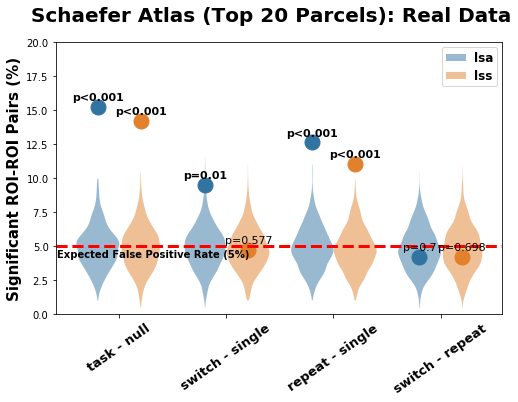

In [342]:
alpha = 0.5
contrast_order = ['taskxnull', 'switchxsingle', 'repeatxsingle', 'switchxrepeat']
method_order = ['lsa', 'lss']
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(x='contrast', y='permutations_percent', hue='estimator',
               inner=None, order=contrast_order, hue_order=method_order, cut=0, ax=ax, linewidth=0,
               data=permutation_schaefer_long_filt_df)

ax.set_ylim(0, 20)

# change the alpha of the violins
contrast_orders = [item for item in contrast_order for i in range(2)]
method_orders = method_order * 4

for contrast, method, poly in zip(contrast_orders, method_orders, ax.collections):
    poly.set_alpha(alpha)
    
    df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
    p_val = permutation_schaefer_long_filt_df.query(df_query)['p_value'].unique()[0]
    ov = permutation_schaefer_long_filt_df.query(df_query)['observed_value_percent'].unique()[0]
    # get x coordinate for dot
    x_coord = poly.get_paths()[0].vertices[0, 0]
    
    # get color for dot
    color = poly.get_facecolor().flatten()
    
    # change the alpha to 1
    color[-1] = 1
    ax.plot(x_coord, ov, 'bo', markersize=15, color=color)
    
    # add text to display each p-value
    # p-values can't actually be zero
    if p_val == 0.0:
        p_str = 'p<' + str(p_val + 0.001)
    else:
        p_str = 'p=' + str(p_val)
    
    # bold significant p-value
    if p_val < 0.05:
        weight = 'bold'
    else:
        weight = 'normal'
    ax.text(x_coord, ov+.5, p_str, ha='center', size=11, weight=weight)
    
# set y label
ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)
    
# set x label
ax.set_xlabel("")

# set x tick marks
new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

# change the alpha of the legend, and make text more visible
[p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
ax.legend_.set_title("")
ax.legend_.texts[0].set(size=12, weight='bold')

# draw false positive line
ax.axhline(5, color='red', linestyle='--', linewidth=3)
ax.text(ax.get_xlim()[0] + 0.01, 4.2, "Expected False Positive Rate (5%)", weight='heavy');

# make title
fig.suptitle("Schaefer Atlas (Top 20 Parcels): Real Data", size=20, weight="heavy")

# save the figure
save_eps(fig, './outputs/data-real_atlas-schaeferbest_participants-filtered_permutation_summary')

## Schaefer Atlas (Top 20 Parcels) Null Data

In [343]:
permutation_schaefer_long_filt_df = permutation_long_df.query("(participants == 'filtered') & (data == 'null') & (atlas == 'schaeferbest')")
permutation_schaefer_long_filt_df.head()

atlas  data       contrast estimator participants  permutations  \
12000  schaeferbest  null  switchxsingle       lss     filtered            10   
12001  schaeferbest  null  switchxsingle       lss     filtered             8   
12002  schaeferbest  null  switchxsingle       lss     filtered             7   
12003  schaeferbest  null  switchxsingle       lss     filtered             6   
12004  schaeferbest  null  switchxsingle       lss     filtered             8   

       observed_value  p_value  
12000               8    0.708  
12001               8    0.708  
12002               8    0.708  
12003               8    0.708  
12004               8    0.708

In [344]:
permutation_schaefer_long_filt_df['observed_value_percent'] = (permutation_schaefer_long_filt_df['observed_value'] / 190) * 100
permutation_schaefer_long_filt_df['permutations_percent'] = (permutation_schaefer_long_filt_df['permutations'] / 190) * 100

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


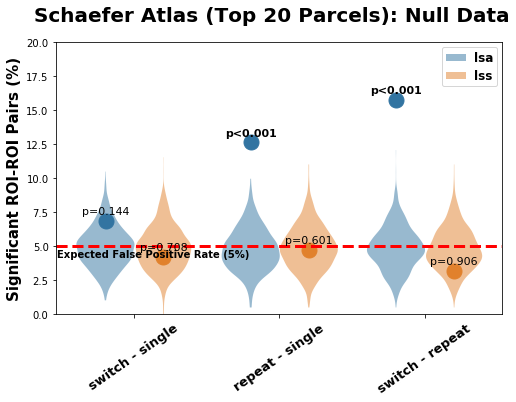

In [345]:
alpha = 0.5
contrast_order = ['switchxsingle', 'repeatxsingle', 'switchxrepeat']
method_order = ['lsa', 'lss']
fig, ax = plt.subplots(figsize=(8, 5))
sns.violinplot(x='contrast', y='permutations_percent', hue='estimator',
               inner=None, order=contrast_order, hue_order=method_order, cut=0, ax=ax, linewidth=0,
               data=permutation_schaefer_long_filt_df)

ax.set_ylim(0, 20)

# change the alpha of the violins
contrast_orders = [item for item in contrast_order for i in range(2)]
method_orders = method_order * 4

for contrast, method, poly in zip(contrast_orders, method_orders, ax.collections):
    poly.set_alpha(alpha)
    
    df_query = "(estimator == '{method}') & (contrast == '{contrast}')".format(method=method, contrast=contrast)
    p_val = permutation_schaefer_long_filt_df.query(df_query)['p_value'].unique()[0]
    ov = permutation_schaefer_long_filt_df.query(df_query)['observed_value_percent'].unique()[0]
    # get x coordinate for dot
    x_coord = poly.get_paths()[0].vertices[0, 0]
    
    # get color for dot
    color = poly.get_facecolor().flatten()
    
    # change the alpha to 1
    color[-1] = 1
    ax.plot(x_coord, ov, 'bo', markersize=15, color=color)
    
    # add text to display each p-value
    # p-values can't actually be zero
    if p_val == 0.0:
        p_str = 'p<' + str(p_val + 0.001)
    else:
        p_str = 'p=' + str(p_val)
    
    # bold significant p-value
    if p_val < 0.05:
        weight = 'bold'
    else:
        weight = 'normal'
    ax.text(x_coord, ov+.5, p_str, ha='center', size=11, weight=weight)
    
# set y label
ax.set_ylabel("Significant ROI-ROI Pairs (%)", weight='heavy', size=15)
    
# set x label
ax.set_xlabel("")

# set x tick marks
new_ticks = [s.get_text().replace('x', ' - ') for s in ax.get_xticklabels()]
ax.set_xticklabels(new_ticks, fontdict={'weight': 'heavy', 'size': 13}, rotation=35)

# change the alpha of the legend, and make text more visible
[p.set(alpha=alpha, facecolor=p.get_facecolor()) for p in ax.legend_.get_patches()];
ax.legend_.set_title("")
ax.legend_.texts[0].set(size=12, weight='bold')

# draw false positive line
ax.axhline(5, color='red', linestyle='--', linewidth=3)
ax.text(ax.get_xlim()[0] + 0.01, 4.2, "Expected False Positive Rate (5%)", weight='heavy');

# make title
fig.suptitle("Schaefer Atlas (Top 20 Parcels): Null Data", size=20, weight="heavy")

# save the figure
save_eps(fig, './outputs/data-null_atlas-schaeferbest_participants-filtered_permutation_summary')

## Binomial Distribution Analysis

In [325]:
q_atlas = '(atlas == "{}")'
q_contrast = '(contrast == "{}")'
q_estimator = '(estimator == "{}")'
q_participants = '(participants == "{}")'
q_data = '(data == "{}")'

atlas_roi_roi_totals = {'schaefer': 79800, 'schaeferbest': 190, 'activation': 210}

In [326]:
# compare real/null
# positive means real data has a larger number of findings, negative means null has a larger number of findings
for atlas in permutation_df['atlas'].unique():
    for contrast in ['switchxsingle', 'repeatxsingle', 'switchxrepeat']:
        for estimator in permutation_df['estimator'].unique():
            query_real = []
            query_real.append(q_participants.format("filtered"))
            query_real.append(q_atlas.format(atlas))
            query_real.append(q_contrast.format(contrast))
            query_real.append(q_estimator.format(estimator))
            query_null = query_real.copy()
            query_real.append(q_data.format("real"))
            query_null.append(q_data.format("null"))
            query_real_str = '&'.join(query_real)
            query_null_str = '&'.join(query_null)
            positives = permutation_df.query(query_real_str)["observed_value"].unique()
            false_positives = permutation_df.query(query_null_str)["observed_value"].unique()
            positives = positives[0] if len(positives) == 1 else ValueError("Too Many Values") 
            false_positives = false_positives[0] if len(false_positives) == 1 else ValueError("Too Many Values")
            nobs = atlas_roi_roi_totals[atlas]
            chi2, p_value, _ = proportions_chisquare([positives, false_positives], nobs)
            
            # calculate cohen's h
            p1 = positives / nobs
            p2 = false_positives / nobs
            
            psi_1 = 2*np.arcsin(p1)
            psi_2 = 2*np.arcsin(p2)
            
            cohen_h = psi_1 - psi_2
            print(atlas, contrast, estimator, ":", cohen_h)

schaefer switchxsingle lss : 0.038299592595271964
schaefer switchxsingle lsa : 0.04403994895160303
schaefer repeatxsingle lss : -0.02090865386327148
schaefer repeatxsingle lsa : 0.060025501476993925
schaefer switchxrepeat lss : -0.024616836412561835
schaefer switchxrepeat lsa : 0.03135410811190102
schaeferbest switchxsingle lss : 0.010536877492127589
schaeferbest switchxsingle lsa : 0.05280915777492093
schaeferbest repeatxsingle lss : 0.12673288361222423
schaeferbest repeatxsingle lsa : 0.0
schaeferbest switchxrepeat lss : 0.021067031730019517
schaeferbest switchxrepeat lsa : -0.23288113293808443
activation switchxsingle lss : -0.028614612373804277
activation switchxsingle lsa : -0.009538131158679589
activation repeatxsingle lss : 0.038180764957890495
activation repeatxsingle lsa : 0.10506071707431335
activation switchxrepeat lss : 0.028578234060599016
activation switchxrepeat lsa : 0.028630897609715045


In [327]:
# compare lss/lsa (lss - lsa)
# positive means lss has a higher proportion, negative means lsa has a higher proportion
for atlas in permutation_df['atlas'].unique():
    for contrast in ['switchxsingle', 'repeatxsingle', 'switchxrepeat']:
        for data in permutation_df['data'].unique():
            query_lss = []
            query_lss.append(q_participants.format("filtered"))
            query_lss.append(q_atlas.format(atlas))
            query_lss.append(q_contrast.format(contrast))
            query_lss.append(q_data.format(data))
            query_lsa = query_lss.copy()
            query_lss.append(q_estimator.format("lss"))
            query_lsa.append(q_estimator.format("lsa"))
            query_lss_str = '&'.join(query_lss)
            query_lsa_str = '&'.join(query_lsa)
            positives = permutation_df.query(query_lss_str)["observed_value"].unique()
            false_positives = permutation_df.query(query_lsa_str)["observed_value"].unique()
            positives = positives[0] if len(positives) == 1 else ValueError("Too Many Values") 
            false_positives = false_positives[0] if len(false_positives) == 1 else ValueError("Too Many Values")
            nobs = atlas_roi_roi_totals[atlas]
            chi2, p_value, _ = proportions_chisquare([positives, false_positives], nobs)
            
            # calculate cohen's h
            p1 = positives / nobs
            p2 = false_positives / nobs
            
            psi_1 = 2*np.arcsin(p1)
            psi_2 = 2*np.arcsin(p2)
            
            cohen_h = psi_1 - psi_2
            print(atlas, contrast, data, ":", cohen_h)

schaefer switchxsingle real : 0.006588270557202208
schaefer switchxsingle null : 0.012328626913533272
schaefer repeatxsingle real : -0.03815683405556772
schaefer repeatxsingle null : 0.04277732128469769
schaefer switchxrepeat real : -0.04244363376105359
schaefer switchxrepeat null : 0.013527310763409267
schaeferbest switchxsingle real : -0.09498595245791593
schaeferbest switchxsingle null : -0.052713672175122586
schaeferbest repeatxsingle real : -0.031803077561833676
schaeferbest repeatxsingle null : -0.15853596117405788
schaeferbest switchxrepeat real : 0.0
schaeferbest switchxrepeat null : -0.25394816466810394
activation switchxsingle real : -0.009535745753840169
activation switchxsingle null : 0.009540735461284519
activation repeatxsingle real : -0.04780607520390309
activation repeatxsingle null : 0.019073876912519758
activation switchxrepeat real : -0.08582826523245575
activation switchxrepeat null : -0.08577560168333973


## Participation Coefficient (Prespecified Community Assignment)

The participation coefficient measures how much a parcel connects to all other parcels, with 1 meaning the parcel is connected to all other parcels equally.

I expect the participation coefficient to be greater (i.e., closer to 1) in the task switch relative to rest, especially in frontal-parietal networks.

**Note**: participation coefficient is calculated separately for positively and negatively signed correlations.
My hypothesis is only for the positively signed correlations.

### Positive Participation Coefficient

### Discussion

There are significant differences between task and rest, but the most represented network is in the Default Mode network, with task showing a higher participation coefficient (as expected)

However, I should run the analysis again allowing the [communities to be decided by an algorithm rather than the schaefer network assignments](https://www.sciencedirect.com/science/article/pii/S0896627316305773?via%3Dihub)

### Negative Participation Coefficient

## Participation Coefficient (Louvain Community Assignment)

### Positive Participation Coefficient

### Negative Participation Coefficient

## Clustering Coefficient
Clustering Coefficient measures the number of local highly clustered nodes (nodes that form triangles of connections).

I expect task to have a higher(?) clustering coefficient relative to rest.
This is a rather expensive computation

## Modularity
Modularity is a measure of within community connections relative to outside community connections.
I expect task to have a lower modularity relative to rest.

## Investigate Beta Correlations between LSS and LSA

In [ ]:
ts_act_lss_bs_objs = nf.get_layout_objects(lss_act_layout,
                                           ['switch', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="taskswitch")
ts_act_lsa_bs_objs = nf.get_layout_objects(lsa_act_layout,
                                           ['switch', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="taskswitch")

In [ ]:
masker = NiftiLabelsMasker(ACT_ATLAS)

In [ ]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False
    otherwise.
    modified from nipype:
    https://github.com/nipy/nipype/blob/b62d80/nipype/algorithms/confounds.py#L1129
    Parameters
    ----------
    points: nparray
        an numobservations by numdimensions numpy array of observations
    thresh: float
        the modified z-score to use as a threshold. Observations with
        a modified z-score (based on the median absolute deviation) greater
        than this value will be classified as outliers.
    Returns
    -------
        A bolean mask, of size numobservations-length array.
    .. note:: References
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
    """
    import numpy as np

    if len(points.shape) == 1:
        points = points[:, None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [ ]:
collector = {}
for lss, lsa in zip(ts_act_lss_bs_objs['single'], ts_act_lsa_bs_objs['single']):
    lss_ts = masker.fit_transform(lss.path)
    lsa_ts = masker.fit_transform(lsa.path)
    outliers = is_outlier(lss_ts) | is_outlier(lsa_ts)
    lss_ts = lss_ts[~outliers]
    lsa_ts = lsa_ts[~outliers]
    correlations = []
    for col in range(lss_ts.shape[1]):
        correlations.append(np.corrcoef(lss_ts[:,col], lsa_ts[:,col])[1,0])
    collector[lss.entities['subject']] = correlations

In [ ]:
columns = nf._read_adj_matrix(fb_act_lss_objs['switch'][0].path).columns
lss_lsa_beta_series_corr = pd.DataFrame.from_dict(collector, orient='index', columns=columns)
lss_lsa_beta_series_corr['average_correlation'] = lss_lsa_beta_series_corr.mean(axis=1)
lss_lsa_beta_series_corr.reset_index(inplace=True)
lss_lsa_beta_series_corr.head()

In [ ]:
lss_lsa_beta_combine = pd.merge(
    lss_lsa_beta_series_corr,
    bold_qa_select.query("task == 'taskswitch'"),
    how='left',
    left_on='index',
    right_on='participant_id')

In [ ]:
lss_lsa_beta_combine['hue'] = lss_lsa_beta_combine['index'].isin(good_participants)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='average_correlation', y='fd_mean', size='tsnr', hue='hue', hue_order=[True, False], data=lss_lsa_beta_combine, ax=ax)
ax.set_xlabel("Correlation between LSS and LSA (Pearson's R)", fontdict={'size': 'large', 'weight': 'heavy'});
ax.set_ylabel("Average Framewise Displacement (mm)", fontdict={'size': 'large', 'weight': 'heavy'});
ax.legend_.texts[0].set_text("INCLUDED");
ax.legend_.texts[3].set_text("TSNR");
ax.legend_.set(bbox_to_anchor=(1.2, 1.05))
save_eps(fig, "./outputs/lss_lsa_noise_relationship")

A high correlation between LSS and LSA means the methods agreed with each other.
The methods do not agree as much as motion increases and TSNR decreases.

### look at bs correlations in the null data

In [ ]:
fb_act_lss_bs_objs = nf.get_layout_objects(lss_act_layout,
                                           ['switch', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="fauxbold")
fb_act_lsa_bs_objs = nf.get_layout_objects(lsa_act_layout,
                                           ['switch', 'repeat', 'single'],
                                           suffix="betaseries", extension="nii.gz",
                                           task="fauxbold")

In [ ]:
masker = NiftiLabelsMasker(ACT_ATLAS)

In [ ]:
fb_collector = {}
for lss, lsa in zip(fb_act_lss_bs_objs['switch'], fb_act_lsa_bs_objs['switch']):
    lss_ts = masker.fit_transform(lss.path)
    lsa_ts = masker.fit_transform(lsa.path)
    outliers = is_outlier(lss_ts) | is_outlier(lsa_ts)
    lss_ts = lss_ts[~outliers]
    lsa_ts = lsa_ts[~outliers]
    correlations = []
    for col in range(lss_ts.shape[1]):
        correlations.append(np.corrcoef(lss_ts[:,col], lsa_ts[:,col])[1,0])
    fb_collector[lss.entities['subject']] = correlations

In [ ]:
columns = nf._read_adj_matrix(fb_act_lss_objs['switch'][0].path).columns
lss_lsa_beta_series_corr = pd.DataFrame.from_dict(fb_collector, orient='index', columns=columns)
lss_lsa_beta_series_corr['average_correlation'] = lss_lsa_beta_series_corr.mean(axis=1)
lss_lsa_beta_series_corr.reset_index(inplace=True)
lss_lsa_beta_series_corr.head()

In [ ]:
lss_lsa_beta_combine = pd.merge(
    lss_lsa_beta_series_corr,
    bold_qa_select.query("task == 'fauxbold'"),
    how='left',
    left_on='index',
    right_on='participant_id')

In [ ]:
lss_lsa_beta_combine['hue'] = lss_lsa_beta_combine['index'].isin(good_participants)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='average_correlation', y='fd_mean', size='tsnr', hue='hue', hue_order=[True, False], data=lss_lsa_beta_combine, ax=ax)
ax.set_xlabel("Correlation between LSS and LSA (Pearson's R)", fontdict={'size': 'large', 'weight': 'heavy'});
ax.set_ylabel("Average Framewise Displacement (mm)", fontdict={'size': 'large', 'weight': 'heavy'});
ax.legend_.texts[0].set_text("INCLUDED");
ax.legend_.texts[3].set_text("TSNR");
ax.legend_.set(bbox_to_anchor=(1.2, 1.05))
save_eps(fig, "./outputs/lss_lsa_noise_relationship")

### Correlate average roi-roi condition specific correlations

Averaging over the 40/60 participants, is there good agreement between LSS's and LSA's pattern of responses?

Yes.

In [223]:
# correlate average matrices
lss_sch_switch_values = nf.bind_matrices(ts_sch_lss_objs['switch'], 'taskswitch').mean(axis=0).values
lsa_sch_switch_values = nf.bind_matrices(ts_sch_lsa_objs['switch'], 'taskswitch').mean(axis=0).values
np.corrcoef(lss_sch_switch_values, lsa_sch_switch_values)

array([[1.        , 0.93980217],
       [0.93980217, 1.        ]])

In [224]:
lss_sch_repeat_values = nf.bind_matrices(ts_sch_lss_objs['repeat'], 'taskswitch').mean(axis=0).values
lsa_sch_repeat_values = nf.bind_matrices(ts_sch_lsa_objs['repeat'], 'taskswitch').mean(axis=0).values
np.corrcoef(lss_sch_repeat_values, lsa_sch_repeat_values)

array([[1.        , 0.94027571],
       [0.94027571, 1.        ]])

In [225]:
lss_sch_single_values = nf.bind_matrices(ts_sch_lss_objs['single'], 'taskswitch').mean(axis=0).values
lsa_sch_single_values = nf.bind_matrices(ts_sch_lsa_objs['single'], 'taskswitch').mean(axis=0).values
np.corrcoef(lss_sch_single_values, lsa_sch_single_values)

array([[1.        , 0.94985342],
       [0.94985342, 1.        ]])

## Validation Strategy